In [38]:
import pandas as pd
import numpy as np 
from datetime import timedelta 
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [39]:
train_df = pd.read_csv('data/ais_train.csv', sep = "|")

In [40]:
vessels_df = pd.read_csv('data/vessels.csv', sep = '|')

In [41]:
ports_df = pd.read_csv('data/ports.csv', sep = '|')
ports_df['latitude_portId'] = ports_df['latitude']
ports_df['longitude_portId'] = ports_df['longitude']
ports_df = ports_df.drop(columns = ['latitude', 'longitude'])

In [42]:
test_df = pd.read_csv('data/ais_test.csv', sep = ',')

In [43]:
schedules_df = pd.read_csv('data/schedules_to_may_2024.csv', sep = '|')

## Preprocessing

In [44]:
train_df = pd.merge(train_df, ports_df, on = 'portId', how = 'left')
train_df = pd.merge(train_df, vessels_df[['vesselId', 'shippingLineId', ]], on = 'vesselId')
train_df = pd.merge(train_df, vessels_df[['vesselId', 'length', 'GT', 'CEU']], on = 'vesselId')
test_df = pd.merge(test_df, vessels_df[['vesselId', 'shippingLineId']], on = 'vesselId')

train_df['time'] = pd.to_datetime(train_df['time'])
test_df['time'] = pd.to_datetime(test_df['time'])

timestamps = train_df[['time', 'vesselId']]

train_df['second'] = train_df['time'].dt.second
train_df['minute'] = train_df['time'].dt.minute
train_df['hour'] = train_df['time'].dt.hour
train_df['day'] = train_df['time'].dt.day
train_df['day_of_week'] = train_df['time'].dt.dayofweek
train_df['month'] = train_df['time'].dt.month

test_df['second'] = test_df['time'].dt.second
test_df['minute'] = test_df['time'].dt.minute
train_df['day'] = train_df['time'].dt.day

test_df['day_of_week'] = test_df['time'].dt.dayofweek
test_df['hour'] = test_df['time'].dt.hour
test_df['month'] = test_df['time'].dt.month

display(train_df)

time    cog   sog  rot  heading  navstat       etaRaw  \
0       2024-01-01 00:00:25  284.0   0.7    0       88        0  01-09 23:00   
1       2024-01-01 00:00:36  109.6   0.0   -6      347        1  12-29 20:00   
2       2024-01-01 00:01:45  111.0  11.0    0      112        0  01-02 09:00   
3       2024-01-01 00:03:11   96.4   0.0    0      142        1  12-31 20:00   
4       2024-01-01 00:03:51  214.0  19.7    0      215        0  01-25 12:00   
...                     ...    ...   ...  ...      ...      ...          ...   
1522060 2024-05-07 23:59:07  359.1  13.4    0        1        0  05-08 05:00   
1522061 2024-05-07 23:59:08   12.3  17.1    0       13        0  05-10 03:00   
1522062 2024-05-07 23:59:08  269.8  14.9   -1      270        0  05-15 23:00   
1522063 2024-05-07 23:59:08    8.0  18.7    0        6        0  05-08 12:45   
1522064 2024-05-07 23:59:08  336.0  14.3    5      337        0  05-07 23:00   

         latitude  longitude                   vesselId  ...  \
0       -34.74370  -57.85130   61e9f3a8b937134a3c4bfdf7  ...   
1         8.89440  -79.47939   61e9f3d4b937134a3c4bff1f  ...   
2        39.19065  -76.47567   61e9f436b937134a3c4c0131  ...   
3       -34.41189  151.02067   61e9f3b4b937134a3c4bfe77  ...   
4        35.88379   -5.91636   61e9f41bb937134a3c4c0087  ...   
...           ...        ...                        ...  ...   
1522060  52.19131   -5.82223  clh6aqawa0002gh0zypfa5dut  ...   
1522061  38.96142  -12.00502   61e9f3aeb937134a3c4bfe43  ...   
1522062  49.71372   -5.22042   61e9f43db937134a3c4c0169  ...   
1522063  38.27895   10.78280   61e9f469b937134a3c4c029b  ...   
1522064  38.98635  -75.13275   62080cff66fc0a8e43c6123a  ...   

                   shippingLineId  length     GT   CEU second minute  hour  \
0        61ec65aea8cafc0e93f0e900  199.00  57718  6500     25      0     0   
1        61be24564ea00ae59d0fe37a  199.97  59583  5174     36      0     0   
2        61be24564ea00ae59d0fe379  199.00  59217  6402     45      1     0   
3        61a8e672f9cba188601e84ac  199.00  55598  5849     11      3     0   
4        61be24564ea00ae59d0fe37a  199.95  58939  5219     51      3     0   
...                           ...     ...    ...   ...    ...    ...   ...   
1522060  61a8e673f9cba188601e84b3  182.00  21005   300      7     59    23   
1522061  61a8e672f9cba188601e84ac  199.00  61328  6354      8     59    23   
1522062  61a8e673f9cba188601e84b9  199.96  72700  7429      8     59    23   
1522063  61ec6303a8cafc0e93f0e8f3  186.00  25995  1400      8     59    23   
1522064  61be24564ea00ae59d0fe379  200.00  59454  6215      8     59    23   

         day day_of_week  month  
0          1           0      1  
1          1           0      1  
2          1           0      1  
3          1           0      1  
4          1           0      1  
...      ...         ...    ...  
1522060    7           1      5  
1522061    7           1      5  
1522062    7           1      5  
1522063    7           1      5  
1522064    7           1      5  

[1522065 rows x 28 columns]

## Feature engineering

In [45]:

le_vesselid = LabelEncoder()
le_vesselid.fit(train_df['vesselId'])
train_df['vesselId'] = le_vesselid.transform(train_df['vesselId'])
test_df['vesselId'] =  le_vesselid.transform(test_df['vesselId'])

le_shippingLineId = LabelEncoder()
le_shippingLineId.fit(train_df['shippingLineId'])
train_df['shippingLineId'] = le_shippingLineId.transform(train_df['shippingLineId'])
test_df['shippingLineId'] = le_shippingLineId.transform(test_df['shippingLineId'])


le_portid = LabelEncoder()
le_portid.fit(train_df['portId'])
train_df['portId'] = le_portid.transform(train_df['portId'])

train_df['navstat'] = pd.Categorical(train_df['navstat']).codes

#train_df = train_df.dropna()

In [46]:
train_df = train_df.sort_values(by = 'vesselId', kind = 'stable')
display(train_df)
display(test_df.sort_values(by = 'vesselId', kind = 'stable'))

time    cog   sog  rot  heading  navstat       etaRaw  \
131115  2024-01-12 14:07:47  308.1  17.1   -6      316        0  01-08 06:00   
131279  2024-01-12 14:31:00  307.6  17.3    5      313        0  01-14 23:30   
131514  2024-01-12 14:57:23  306.8  16.9    5      312        0  01-14 23:30   
131696  2024-01-12 15:18:48  307.9  16.9    6      313        0  01-14 23:30   
131885  2024-01-12 15:39:47  307.0  16.3    7      313        0  01-14 23:30   
...                     ...    ...   ...  ...      ...      ...          ...   
1521244 2024-05-07 22:36:16  324.1  13.5   -2      325        0  05-08 03:00   
1521409 2024-05-07 22:57:05  324.2  13.3   -3      326        0  05-08 03:00   
1521625 2024-05-07 23:17:54  356.5  12.2   -1      354        0  05-08 03:00   
1521821 2024-05-07 23:38:13   52.6  17.3    3       50        0  05-08 03:00   
1522014 2024-05-07 23:59:01   53.6  17.7   -1       51        0  05-08 03:00   

         latitude  longitude  vesselId  ...  shippingLineId length     GT  \
131115    7.50361   77.58340         0  ...               0  199.0  58684   
131279    7.57302   77.49505         0  ...               0  199.0  58684   
131514    7.65043   77.39404         0  ...               0  199.0  58684   
131696    7.71275   77.31394         0  ...               0  199.0  58684   
131885    7.77191   77.23585         0  ...               0  199.0  58684   
...           ...        ...       ...  ...             ...    ...    ...   
1521244  59.63337   21.43237       687  ...               5  191.0  24133   
1521409  59.69588   21.34225       687  ...               5  191.0  24133   
1521625  59.76388   21.35317       687  ...               5  191.0  24133   
1521821  59.83316   21.38489       687  ...               5  191.0  24133   
1522014  59.89167   21.54685       687  ...               5  191.0  24133   

          CEU second minute  hour  day  day_of_week  month  
131115   6500     47      7    14   12            4      1  
131279   6500      0     31    14   12            4      1  
131514   6500     23     57    14   12            4      1  
131696   6500     48     18    15   12            4      1  
131885   6500     47     39    15   12            4      1  
...       ...    ...    ...   ...  ...          ...    ...  
1521244   200     16     36    22    7            1      5  
1521409   200      5     57    22    7            1      5  
1521625   200     54     17    23    7            1      5  
1521821   200     13     38    23    7            1      5  
1522014   200      1     59    23    7            1      5  

[1522065 rows x 28 columns]

ID  vesselId                time  scaling_factor  shippingLineId  \
4          4         1 2024-05-08 00:12:27             0.3              25   
201      201         1 2024-05-08 00:39:27             0.3              25   
583      583         1 2024-05-08 01:33:28             0.3              25   
701      701         1 2024-05-08 01:51:26             0.3              25   
829      829         1 2024-05-08 02:03:29             0.3              25   
...      ...       ...                 ...             ...             ...   
51161  51161       687 2024-05-12 22:37:33             0.1               5   
51302  51302       687 2024-05-12 22:58:05             0.1               5   
51444  51444       687 2024-05-12 23:18:20             0.1               5   
51595  51595       687 2024-05-12 23:39:21             0.1               5   
51654  51654       687 2024-05-12 23:59:03             0.1               5   

       second  minute  day_of_week  hour  month  
4          27      12            2     0      5  
201        27      39            2     0      5  
583        28      33            2     1      5  
701        26      51            2     1      5  
829        29       3            2     2      5  
...       ...     ...          ...   ...    ...  
51161      33      37            6    22      5  
51302       5      58            6    22      5  
51444      20      18            6    23      5  
51595      21      39            6    23      5  
51654       3      59            6    23      5  

[51739 rows x 10 columns]

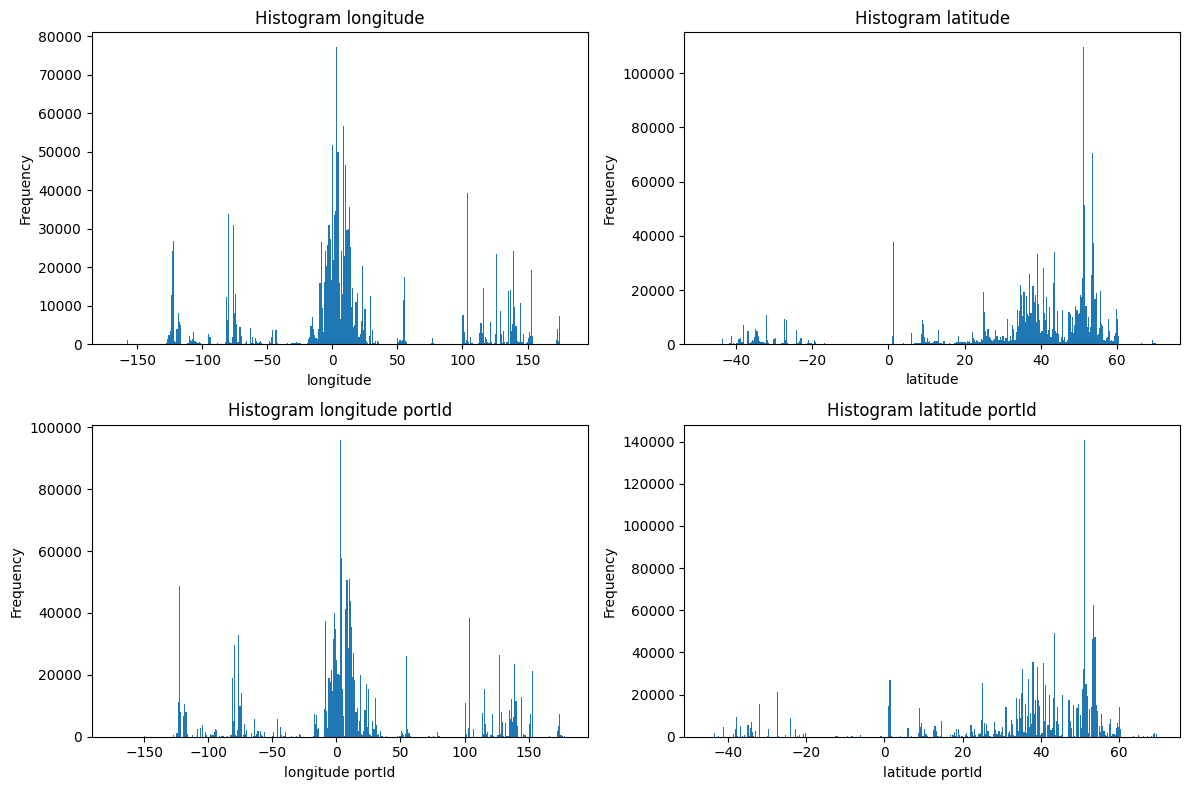

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

train_df['longitude'].plot(kind='hist', bins=400, ax=axes[0,0], title='Histogram longitude', xlabel = 'longitude')

train_df['latitude'].plot(kind='hist', bins=400, ax=axes[0,1], title='Histogram latitude', xlabel = 'latitude')

train_df['longitude_portId'].plot(kind='hist', bins=400, ax=axes[1,0], title='Histogram longitude portId', xlabel= 'longitude portId')

train_df['latitude_portId'].plot(kind='hist', bins=400, ax=axes[1,1], title='Histogram latitude portId', xlabel = 'latitude portId')

plt.tight_layout()
plt.show()


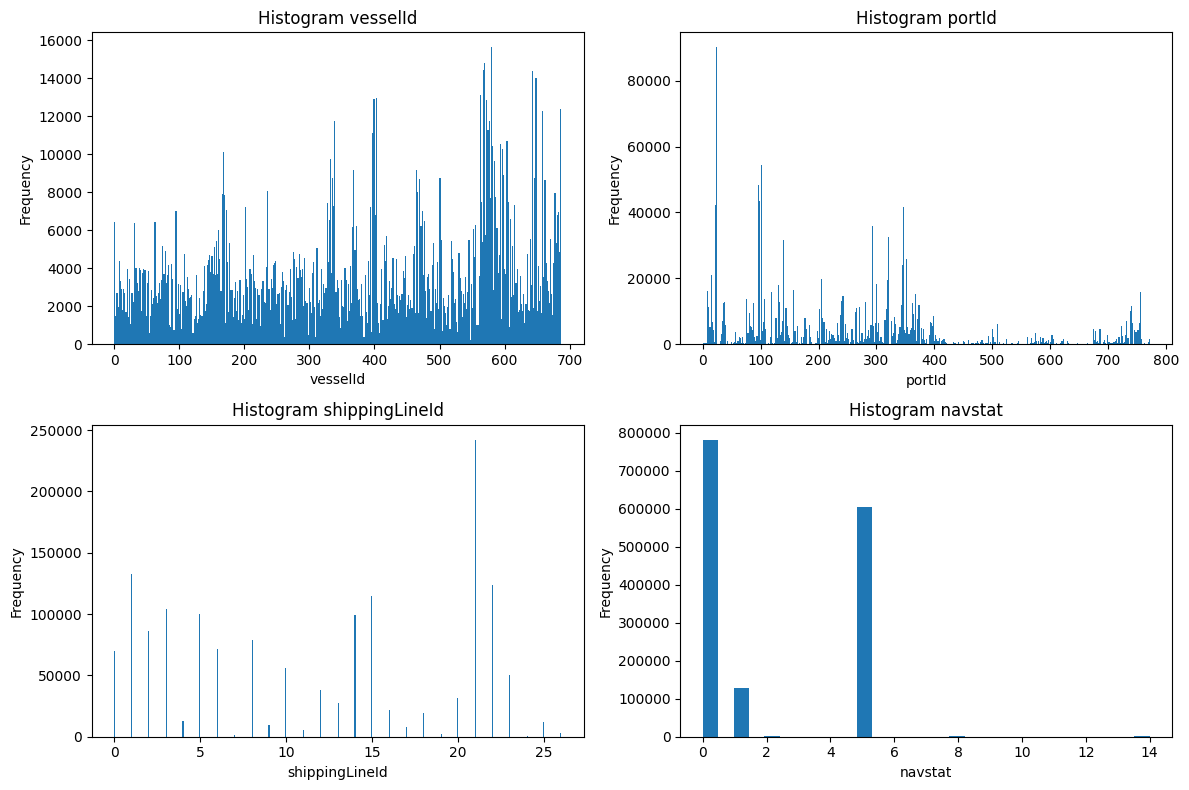

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

train_df['vesselId'].plot(kind='hist', bins=400, ax=axes[0,0], title='Histogram vesselId', xlabel = 'vesselId')

train_df['portId'].plot(kind='hist', bins=400, ax=axes[0,1], title='Histogram portId', xlabel = 'portId')

train_df['shippingLineId'].plot(kind='hist', bins=400, ax=axes[1,0], title='Histogram shippingLineId', xlabel= 'shippingLineId')

train_df['navstat'].plot(kind='hist', bins=29, ax=axes[1,1], title='Histogram navstat', xlabel= 'navstat')


plt.tight_layout()
plt.show()


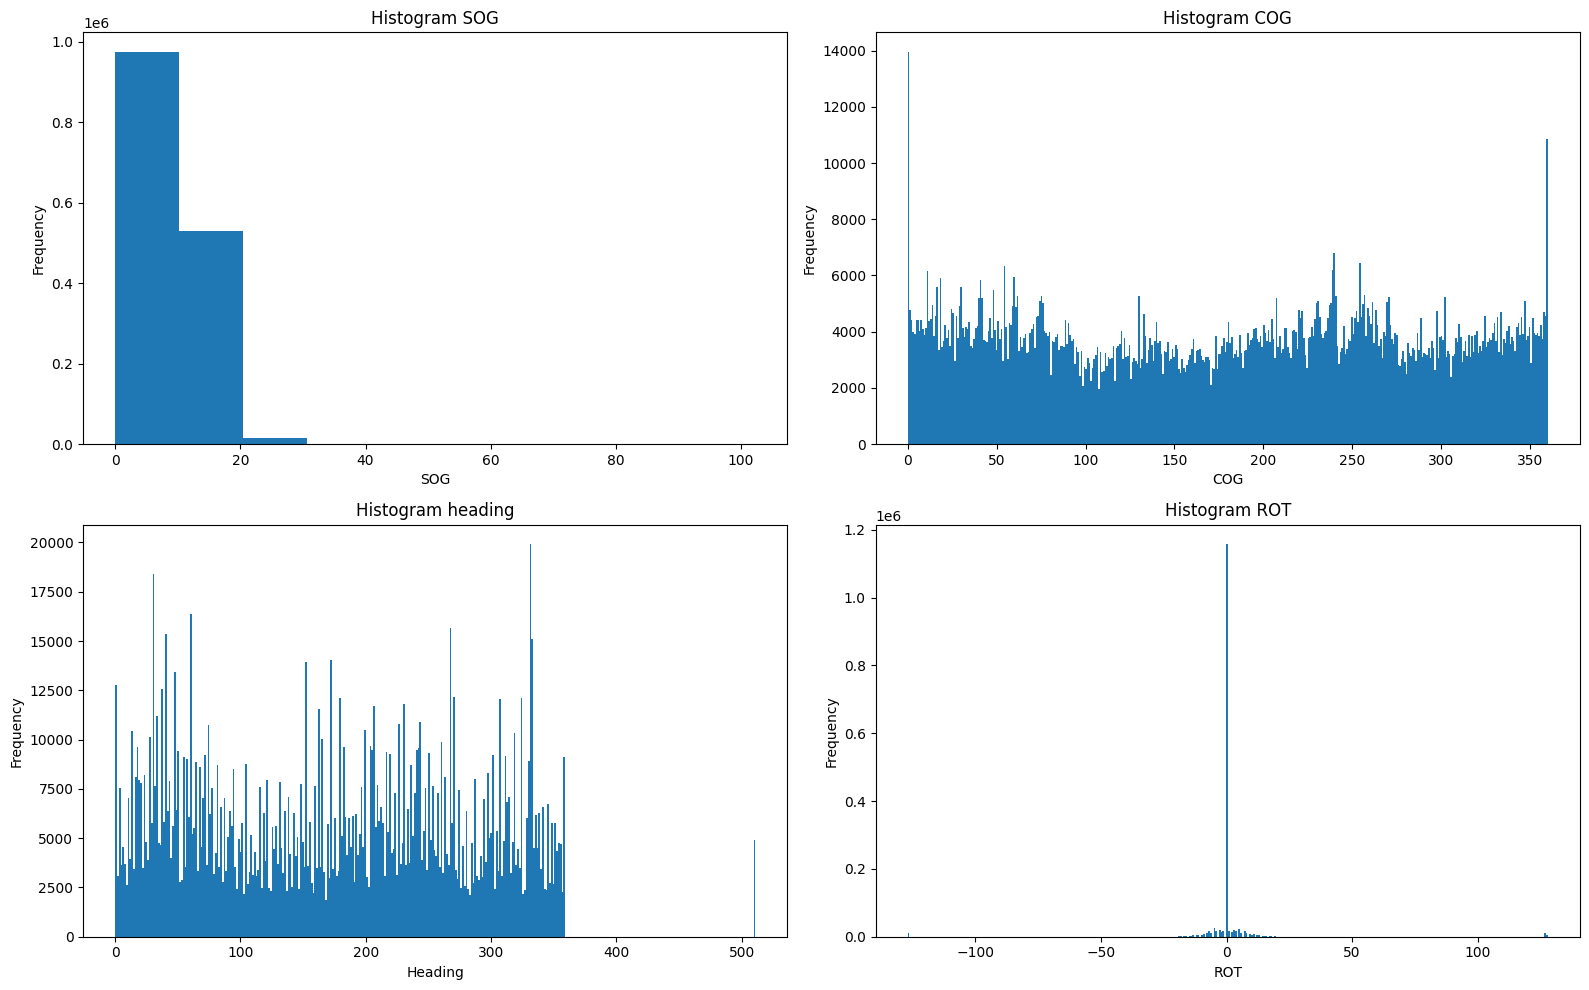

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

train_df['sog'].plot(kind='hist', bins=10, ax=axes[0,0], title='Histogram SOG', xlabel = 'SOG')

train_df['cog'].plot(kind='hist', bins=400, ax=axes[0,1], title='Histogram COG', xlabel = 'COG')

train_df['heading'].plot(kind='hist', bins=360, ax=axes[1,0], title='Histogram heading', xlabel = 'Heading')

train_df['rot'].plot(kind='hist', bins=360, ax=axes[1,1], title='Histogram ROT', xlabel= 'ROT')

plt.tight_layout()
plt.show()

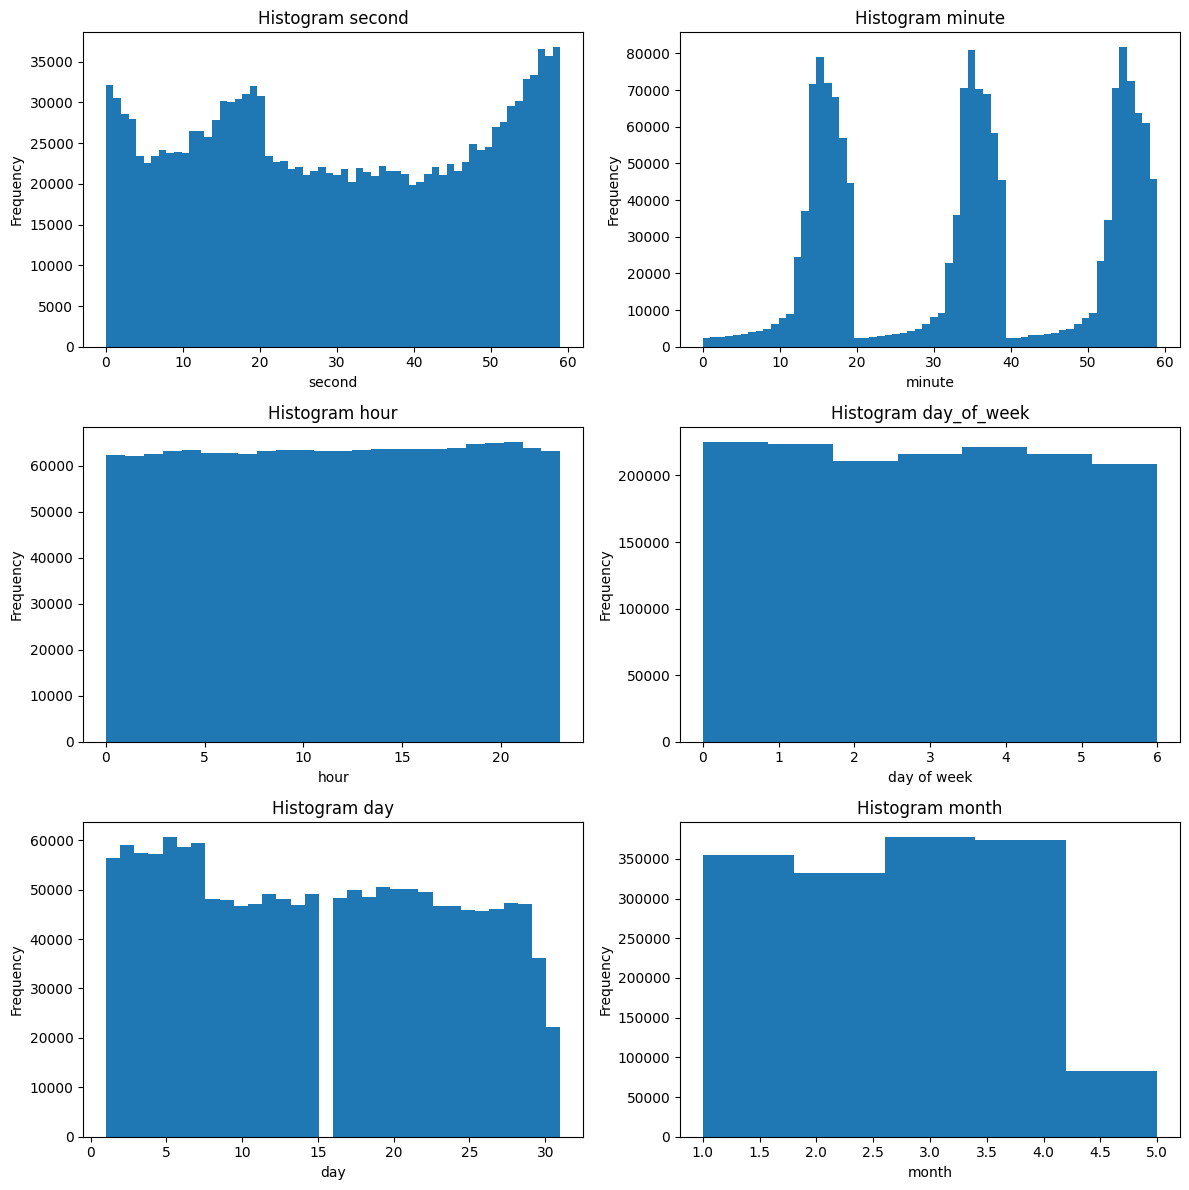

In [50]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (12,12))


train_df['second'].plot(kind = 'hist', bins = 60, ax= ax[0,0], title = f'Histogram second', xlabel = f'second')

train_df['minute'].plot(kind = 'hist', bins = 60, ax= ax[0,1], title = f'Histogram minute', xlabel = f'minute')

train_df['hour'].plot(kind = 'hist', bins = 24, ax= ax[1,0], title = f'Histogram hour', xlabel = f'hour')

train_df['day_of_week'].plot(kind = 'hist', bins = 7, ax= ax[1,1], title = f'Histogram day_of_week', xlabel = f'day of week')

train_df['day'].plot(kind = 'hist', bins = 32, ax= ax[2,0], title = f'Histogram day', xlabel = f'day')

train_df['month'].plot(kind = 'hist', bins = 5, ax= ax[2,1], title = f'Histogram month', xlabel = f'month')

plt.tight_layout()
plt.show()

Number of Nan in lenght: 0
Number of GT in lenght: 0


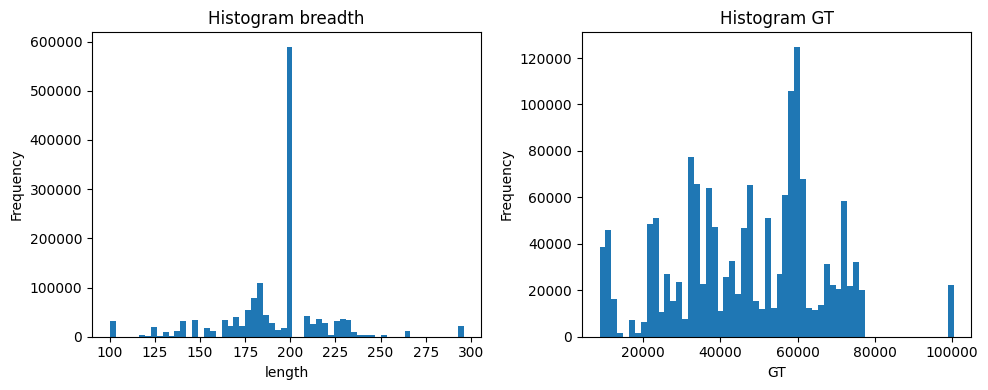

time    cog   sog  rot  heading  navstat       etaRaw  \
131115  2024-01-12 14:07:47  308.1  17.1   -6      316        0  01-08 06:00   
131279  2024-01-12 14:31:00  307.6  17.3    5      313        0  01-14 23:30   
131514  2024-01-12 14:57:23  306.8  16.9    5      312        0  01-14 23:30   
131696  2024-01-12 15:18:48  307.9  16.9    6      313        0  01-14 23:30   
131885  2024-01-12 15:39:47  307.0  16.3    7      313        0  01-14 23:30   
...                     ...    ...   ...  ...      ...      ...          ...   
1521244 2024-05-07 22:36:16  324.1  13.5   -2      325        0  05-08 03:00   
1521409 2024-05-07 22:57:05  324.2  13.3   -3      326        0  05-08 03:00   
1521625 2024-05-07 23:17:54  356.5  12.2   -1      354        0  05-08 03:00   
1521821 2024-05-07 23:38:13   52.6  17.3    3       50        0  05-08 03:00   
1522014 2024-05-07 23:59:01   53.6  17.7   -1       51        0  05-08 03:00   

         latitude  longitude  vesselId  ...  shippingLineId length     GT  \
131115    7.50361   77.58340         0  ...               0  199.0  58684   
131279    7.57302   77.49505         0  ...               0  199.0  58684   
131514    7.65043   77.39404         0  ...               0  199.0  58684   
131696    7.71275   77.31394         0  ...               0  199.0  58684   
131885    7.77191   77.23585         0  ...               0  199.0  58684   
...           ...        ...       ...  ...             ...    ...    ...   
1521244  59.63337   21.43237       687  ...               5  191.0  24133   
1521409  59.69588   21.34225       687  ...               5  191.0  24133   
1521625  59.76388   21.35317       687  ...               5  191.0  24133   
1521821  59.83316   21.38489       687  ...               5  191.0  24133   
1522014  59.89167   21.54685       687  ...               5  191.0  24133   

          CEU second minute  hour  day  day_of_week  month  
131115   6500     47      7    14   12            4      1  
131279   6500      0     31    14   12            4      1  
131514   6500     23     57    14   12            4      1  
131696   6500     48     18    15   12            4      1  
131885   6500     47     39    15   12            4      1  
...       ...    ...    ...   ...  ...          ...    ...  
1521244   200     16     36    22    7            1      5  
1521409   200      5     57    22    7            1      5  
1521625   200     54     17    23    7            1      5  
1521821   200     13     38    23    7            1      5  
1522014   200      1     59    23    7            1      5  

[1522065 rows x 28 columns]

In [52]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))

train_df['length'].plot(kind = 'hist', bins = 60, ax= ax[0], title = f'Histogram breadth', xlabel = f'length')

train_df['GT'].plot(kind = 'hist', bins = 60, ax= ax[1], title = f'Histogram GT', xlabel = f'GT')

print(f'Number of Nan in lenght: {sum(np.isnan(train_df['length']))}')
print(f'Number of GT in lenght: {sum(np.isnan(train_df['GT']))}')
plt.tight_layout()
plt.show()

display(train_df)

38
5
18
13
56
69
74
68
51
43
20
74
5
6
60
5
4
12
2
4
3
17


/var/folders/21/q6thhsn14n7gnn88h4prdf1h0000gn/T/ipykernel_17054/2135385797.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (20,4))


1
19
18
1
2


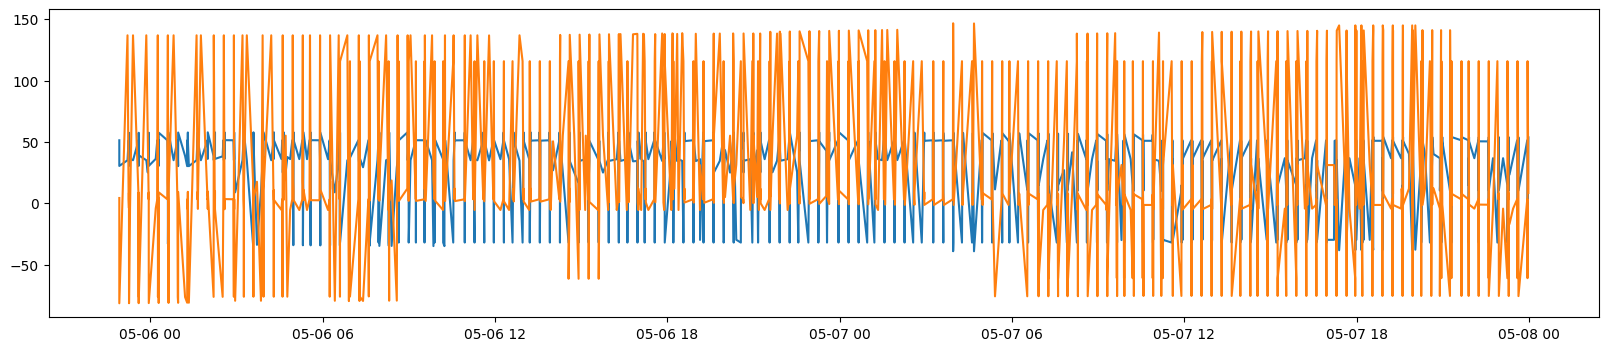

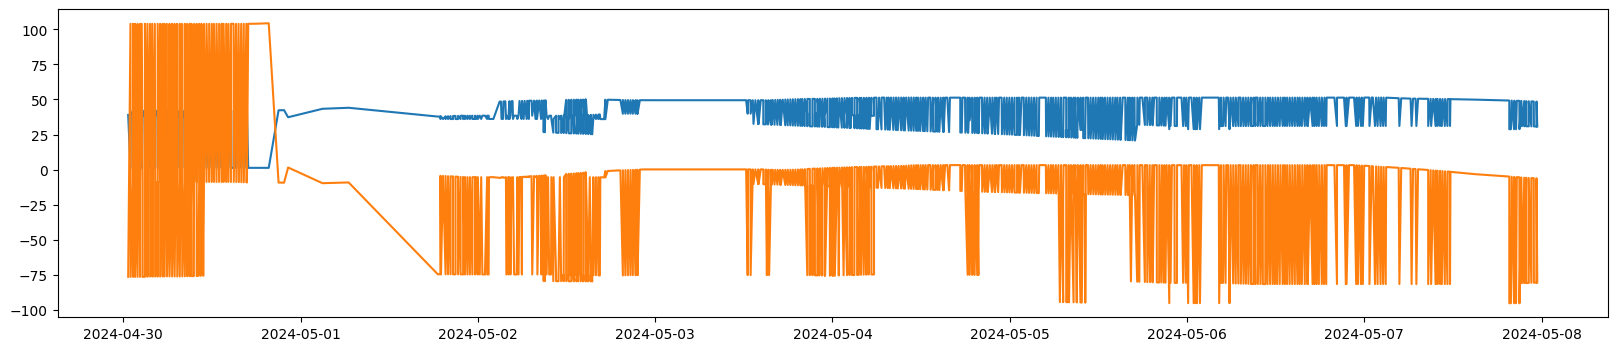

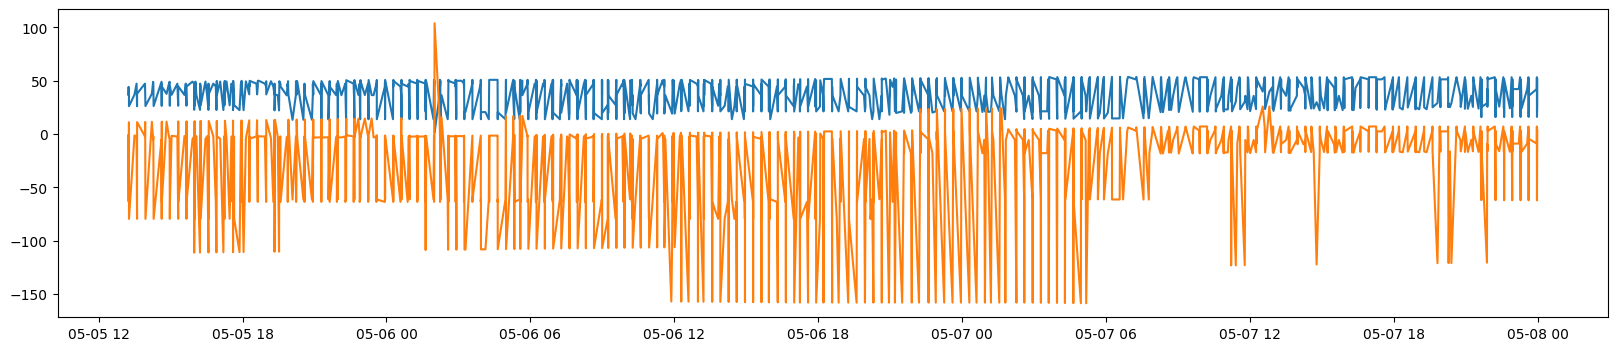

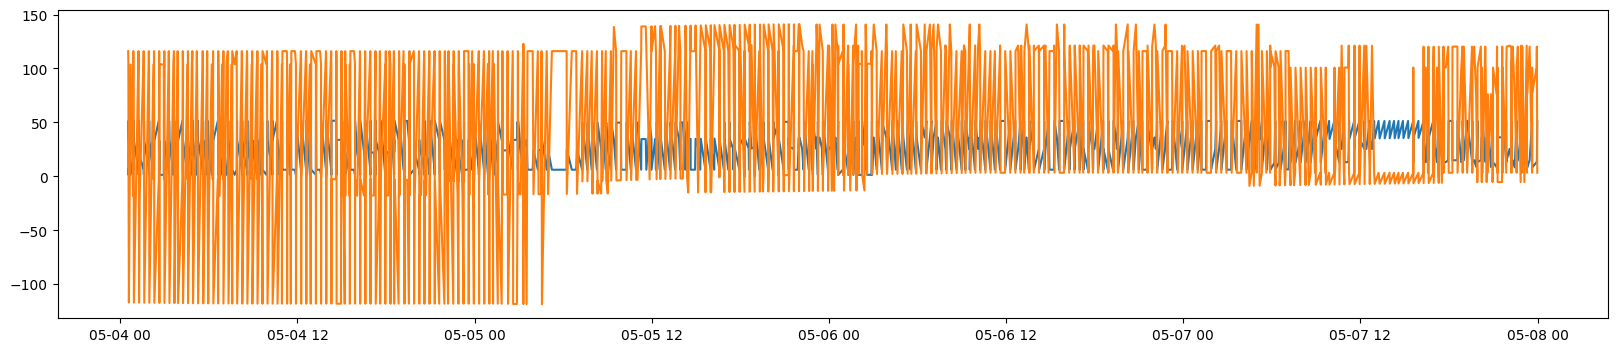

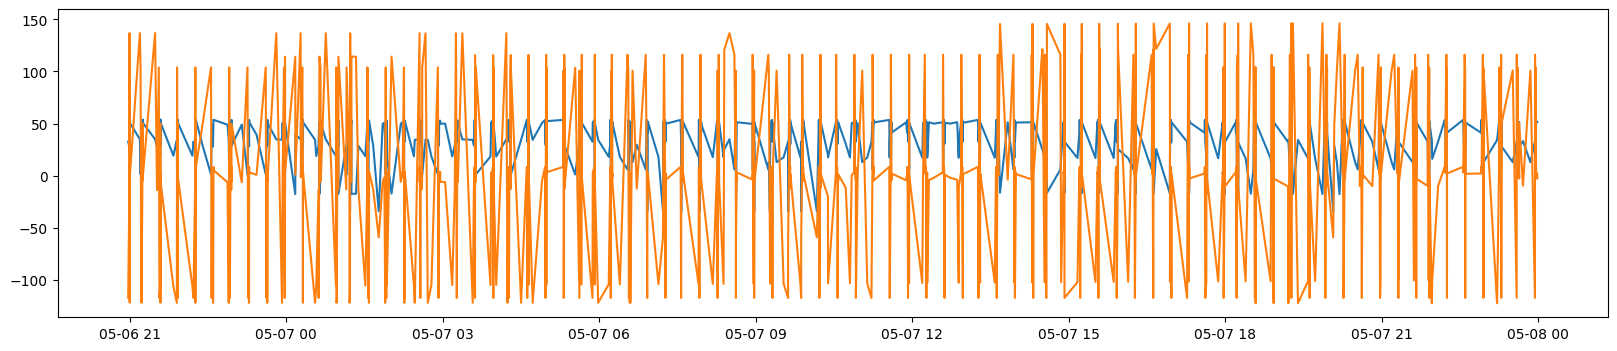

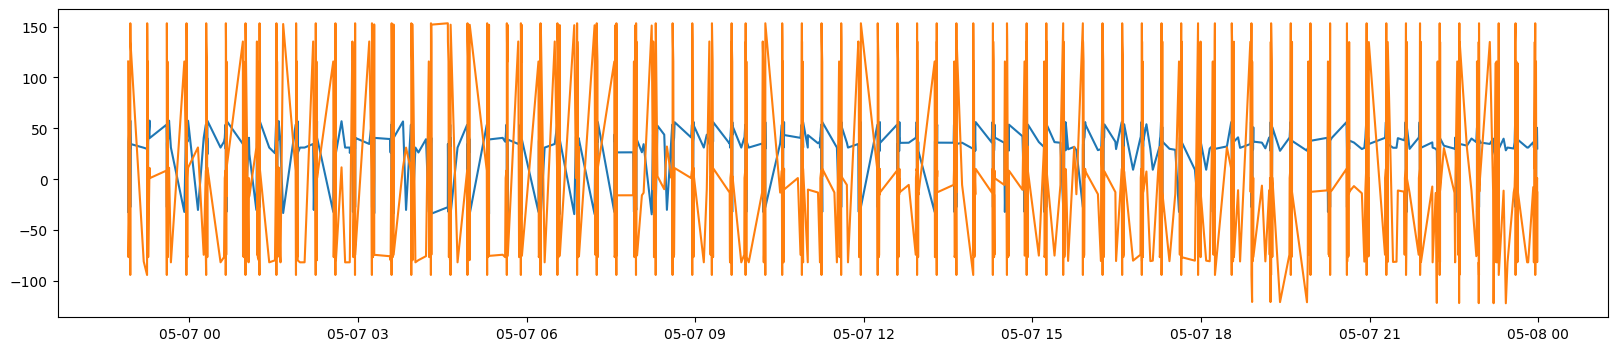

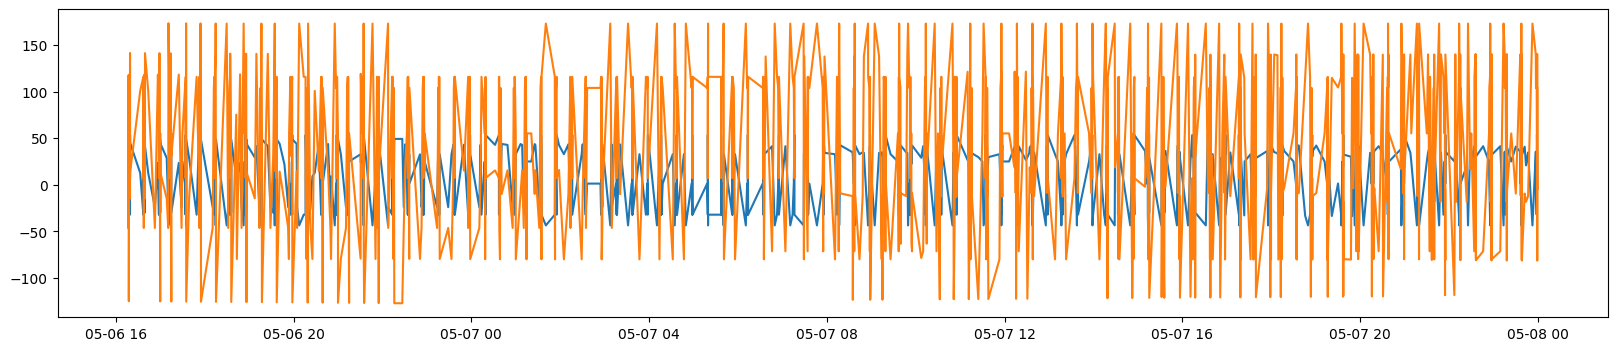

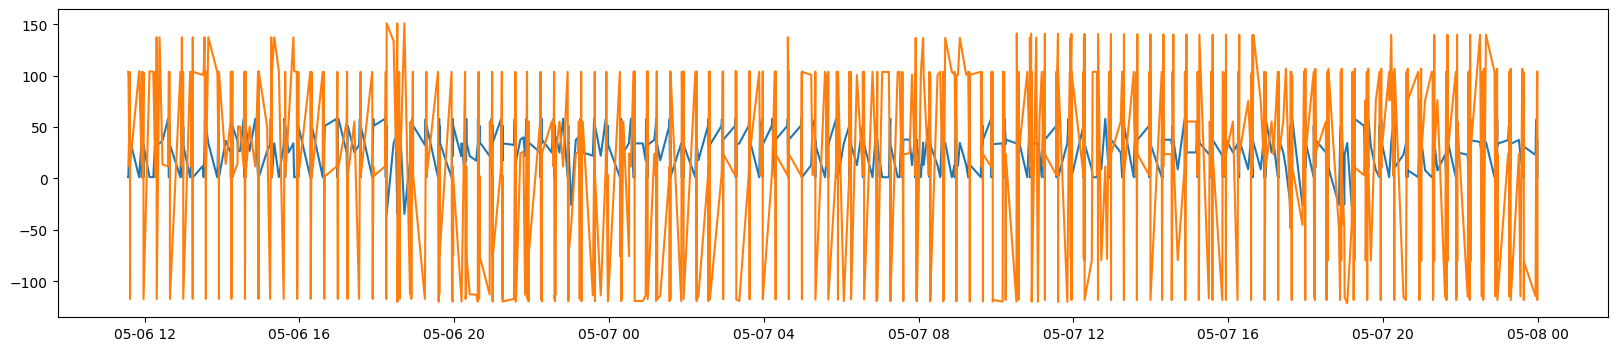

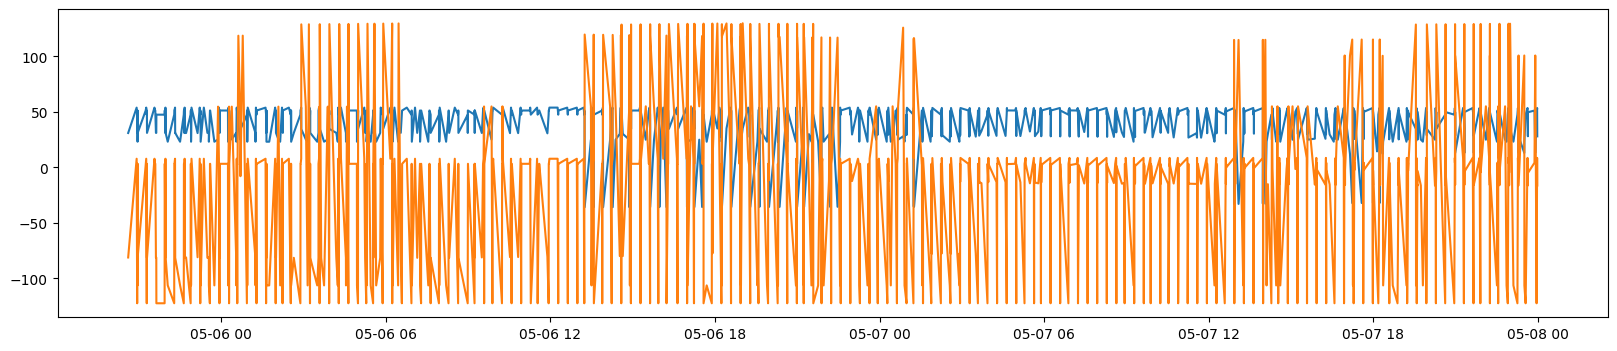

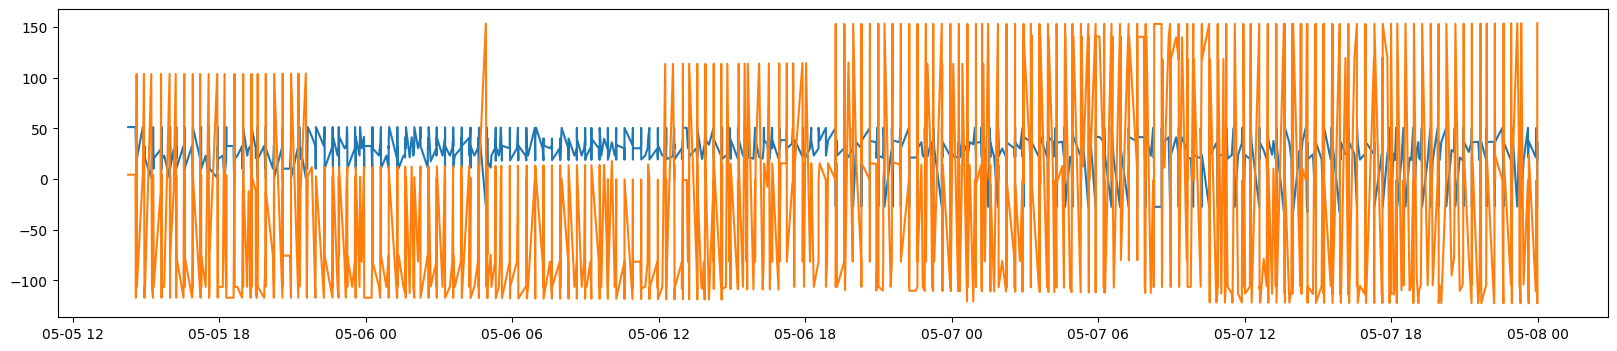

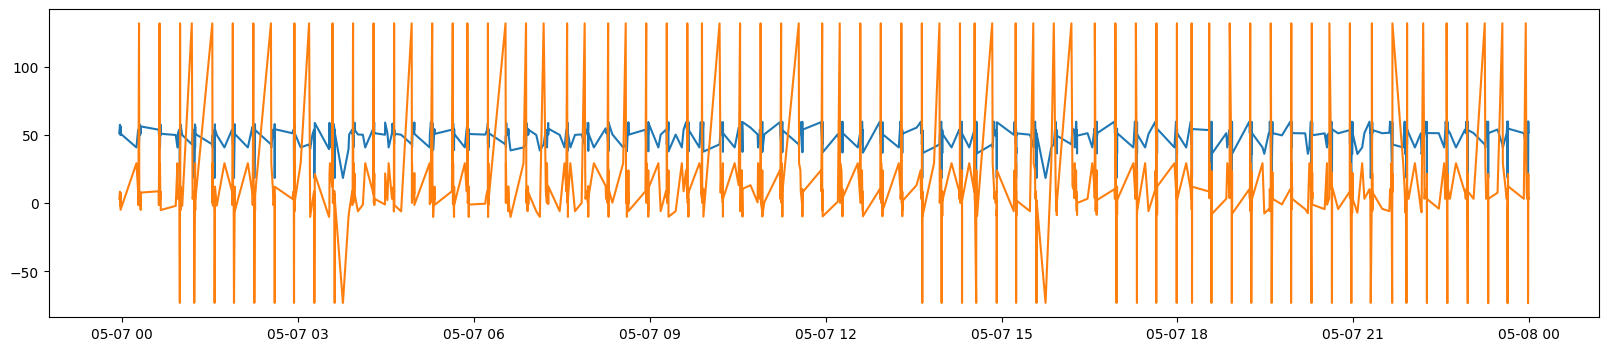

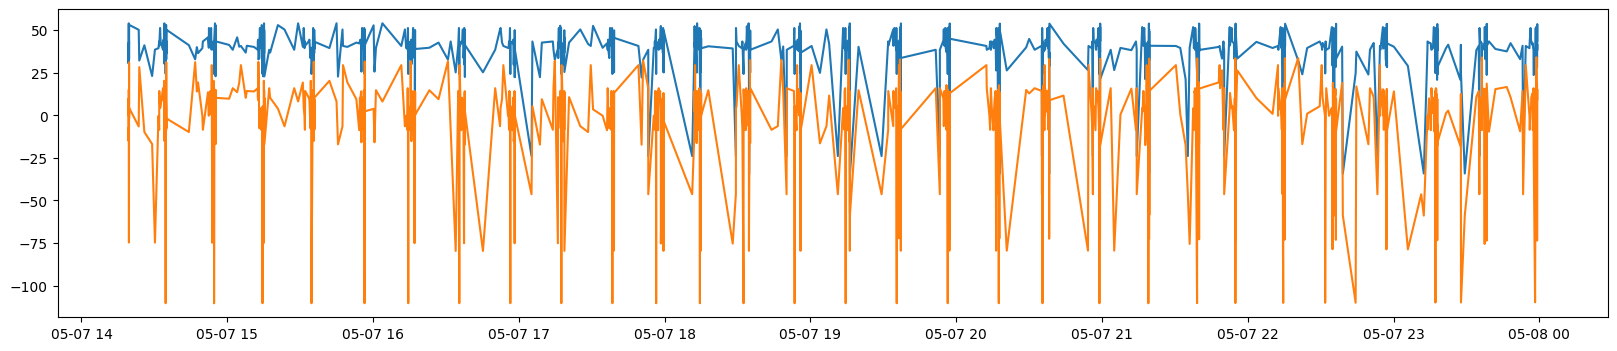

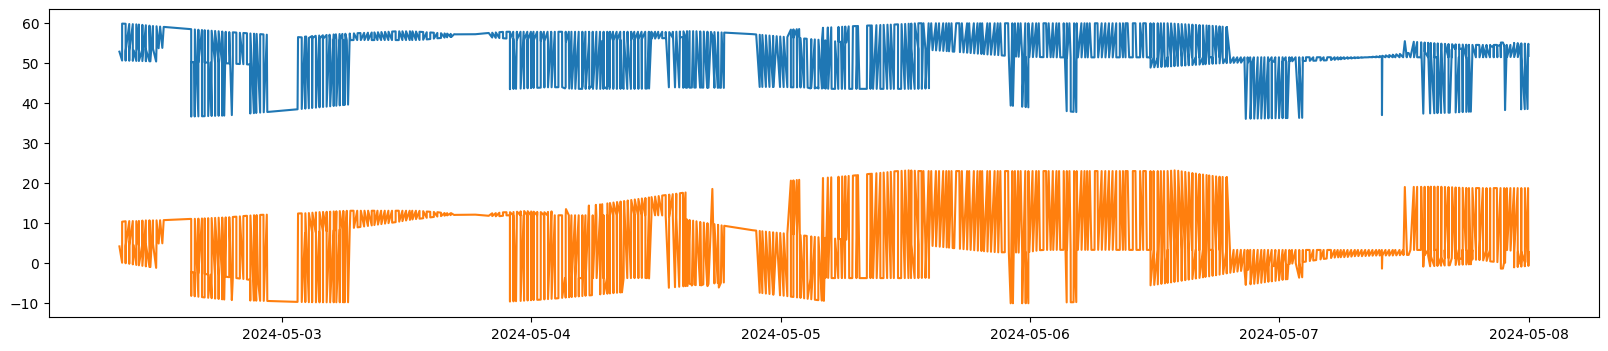

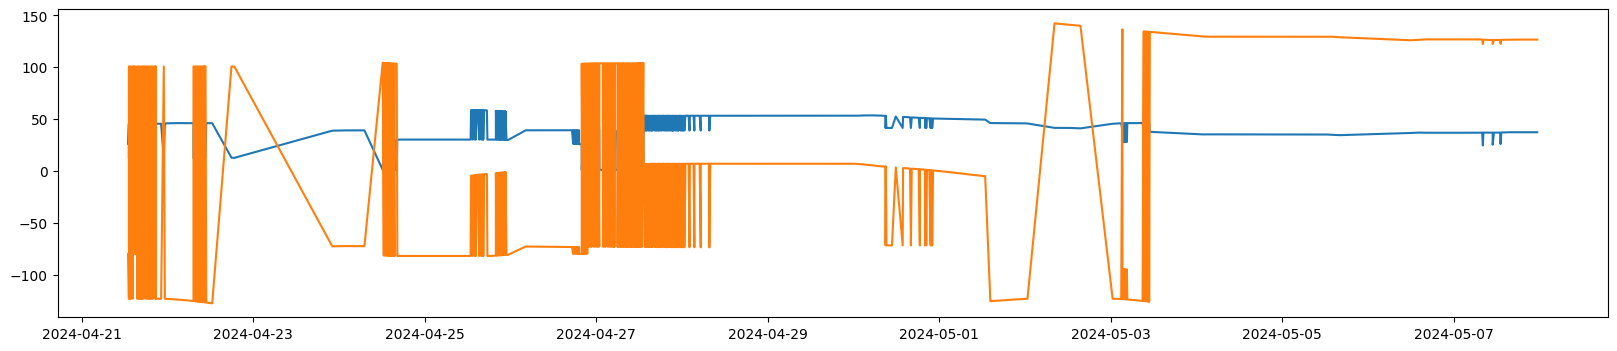

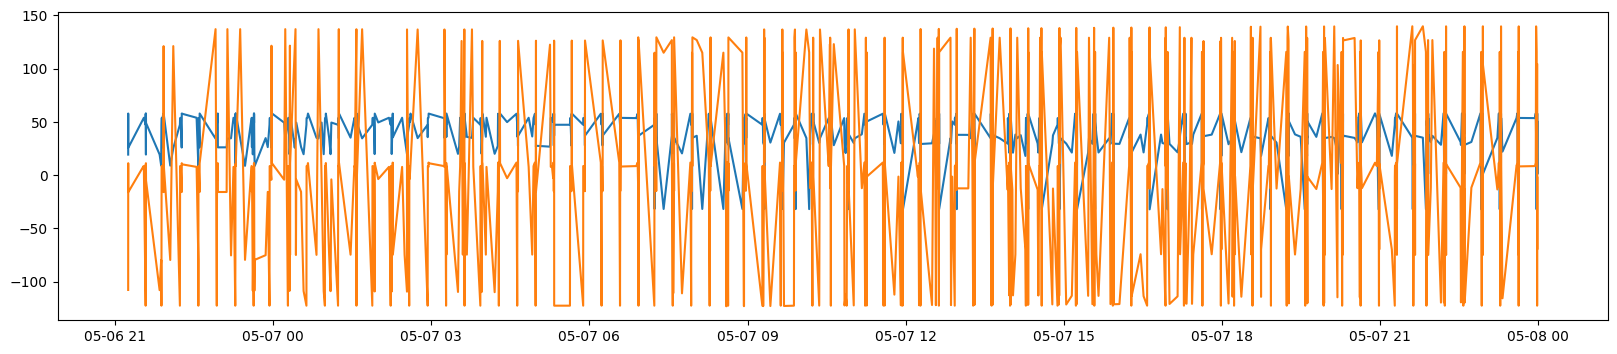

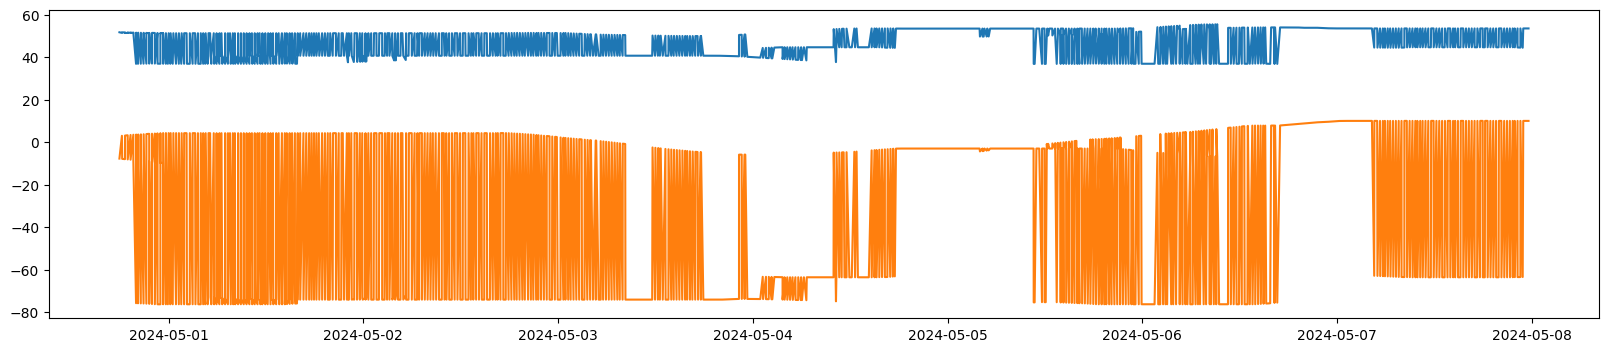

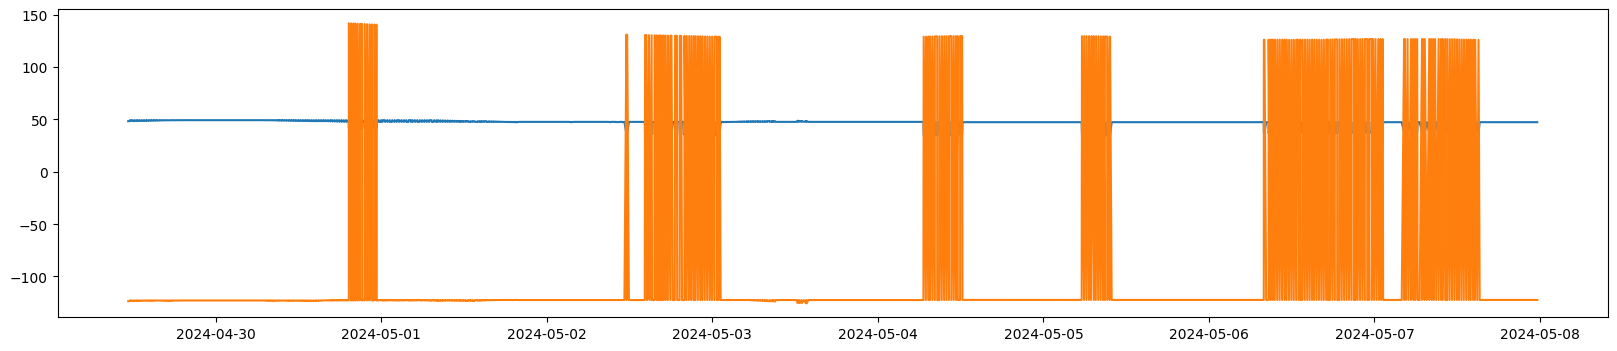

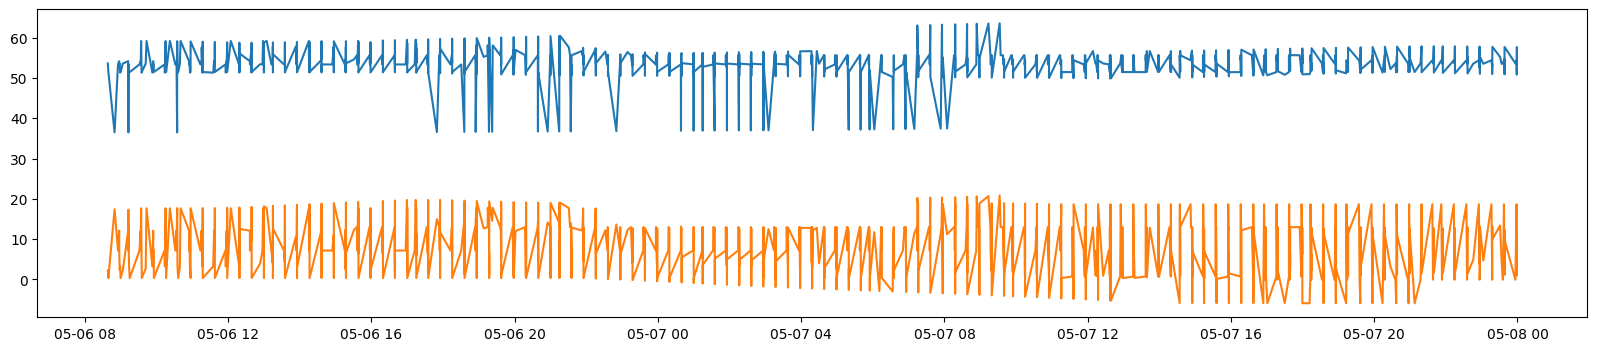

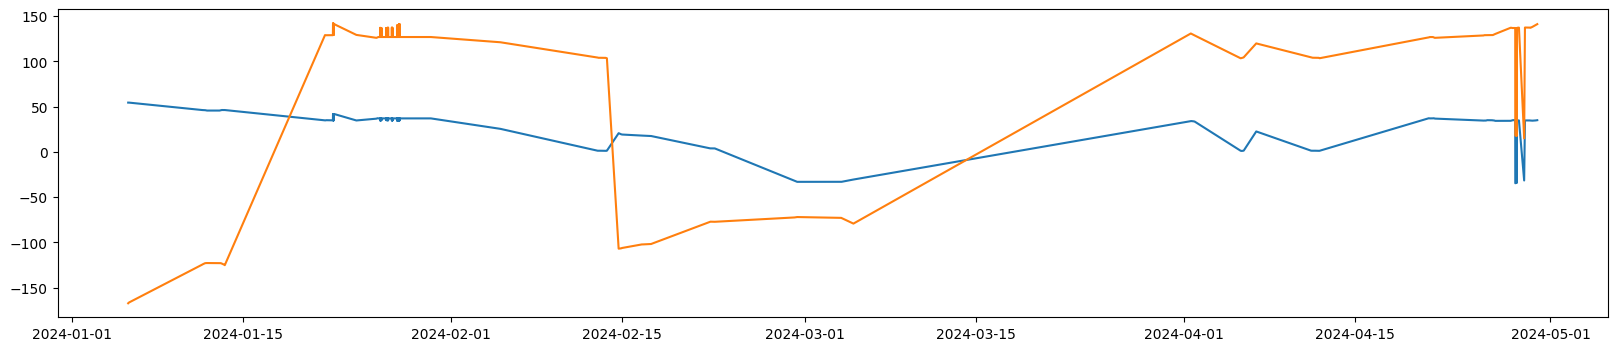

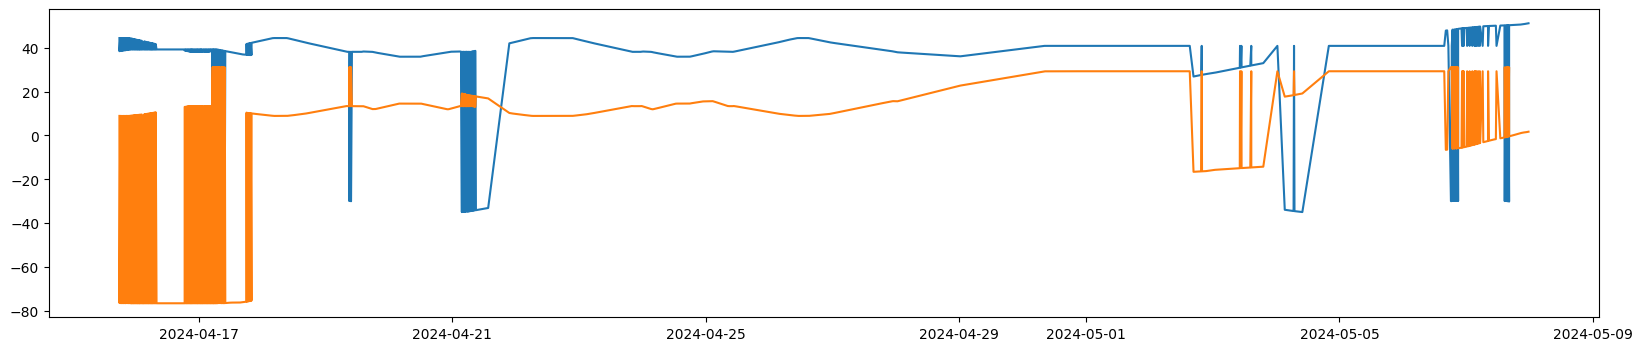

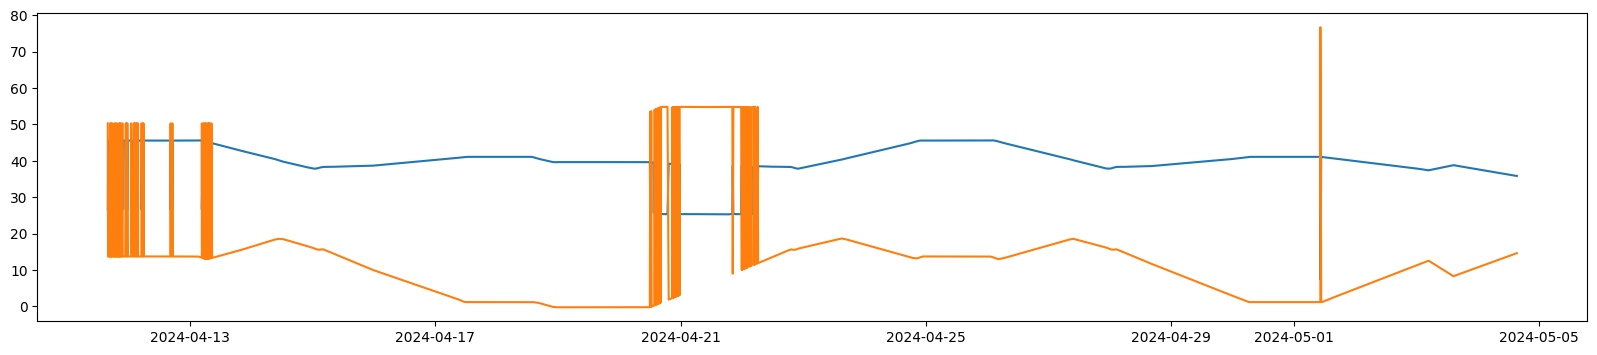

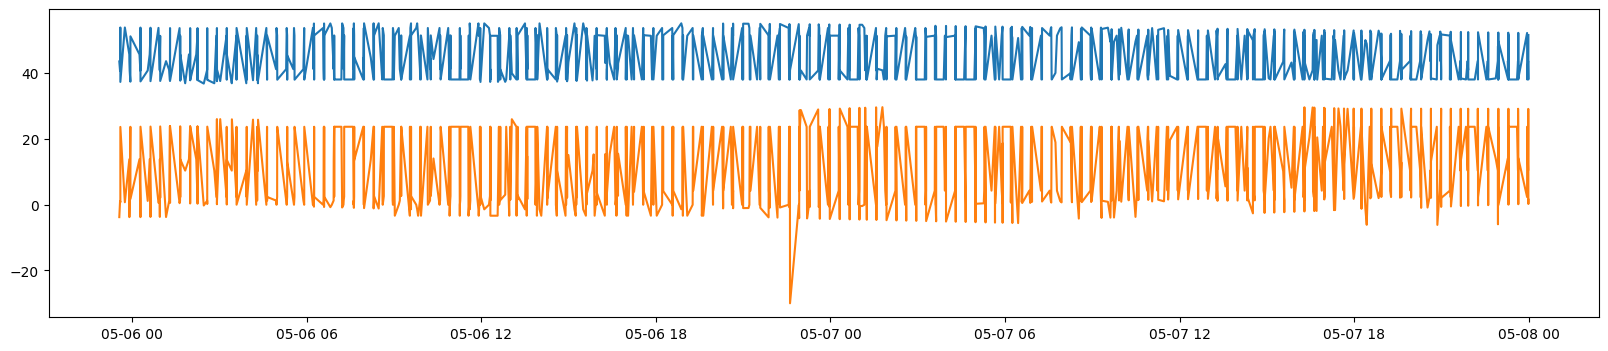

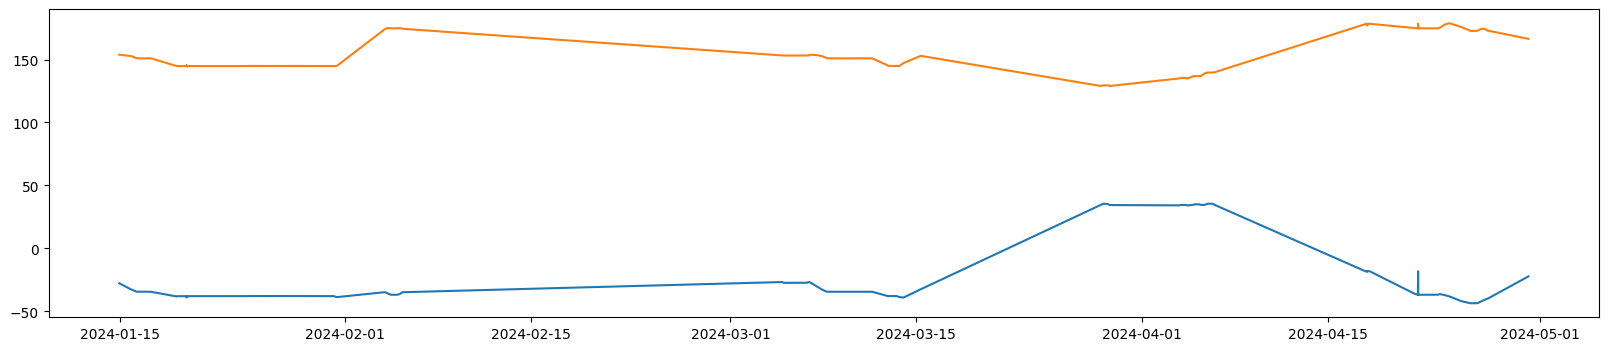

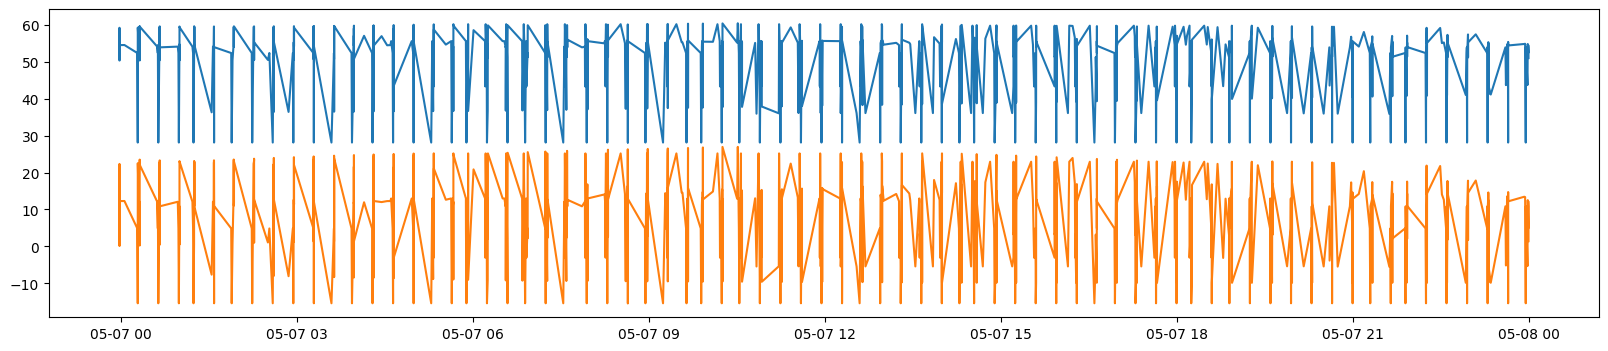

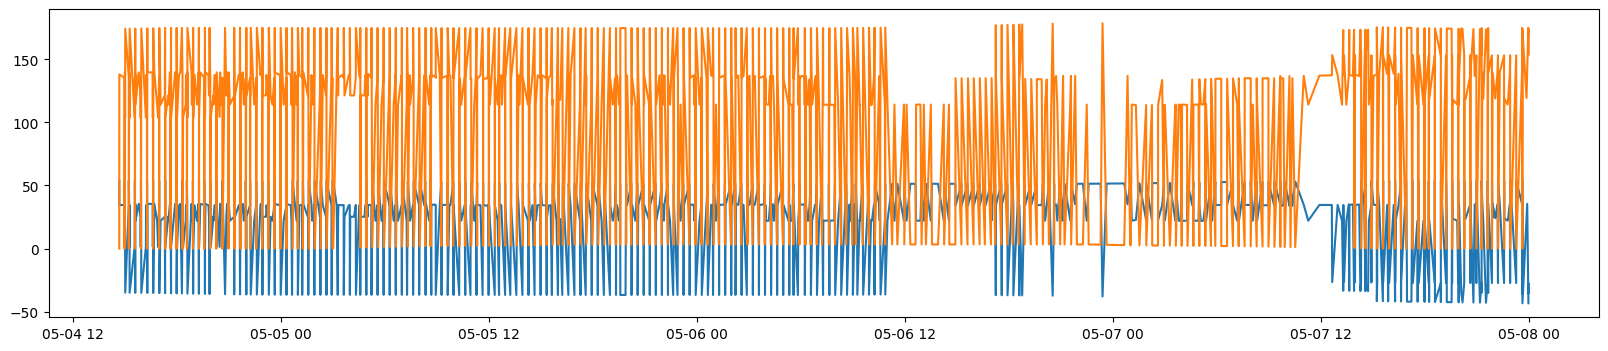

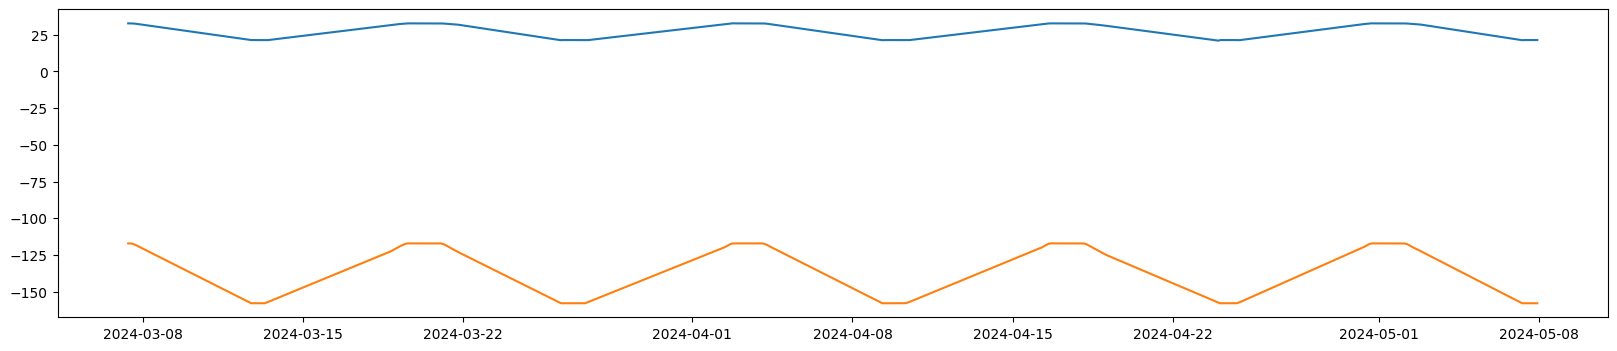

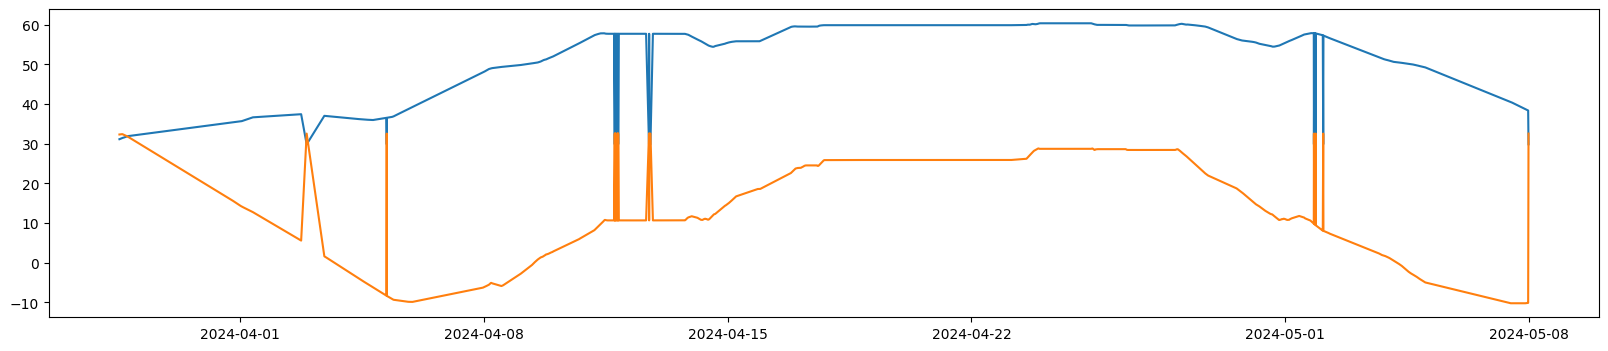

In [53]:
shippingLineId1 = train_df['shippingLineId'].unique()
for i in range(len(shippingLineId1)):
    data_shippingLineId = train_df[train_df['shippingLineId'] == shippingLineId1[i]]

    print(len(data_shippingLineId['vesselId'].unique()))

    data_shippingLineId = data_shippingLineId.sort_values(by = 'time')
    start = -1000
    stop = -1
    plt.figure(figsize = (20,4))
    plt.plot(data_shippingLineId['time'][start:stop], data_shippingLineId['latitude'][start:stop])
    plt.plot(data_shippingLineId['time'][start:stop], data_shippingLineId['longitude'][start:stop])


In [55]:
display(train_df)

time    cog   sog  rot  heading  navstat       etaRaw  \
131115  2024-01-12 14:07:47  308.1  17.1   -6      316        0  01-08 06:00   
131279  2024-01-12 14:31:00  307.6  17.3    5      313        0  01-14 23:30   
131514  2024-01-12 14:57:23  306.8  16.9    5      312        0  01-14 23:30   
131696  2024-01-12 15:18:48  307.9  16.9    6      313        0  01-14 23:30   
131885  2024-01-12 15:39:47  307.0  16.3    7      313        0  01-14 23:30   
...                     ...    ...   ...  ...      ...      ...          ...   
1521244 2024-05-07 22:36:16  324.1  13.5   -2      325        0  05-08 03:00   
1521409 2024-05-07 22:57:05  324.2  13.3   -3      326        0  05-08 03:00   
1521625 2024-05-07 23:17:54  356.5  12.2   -1      354        0  05-08 03:00   
1521821 2024-05-07 23:38:13   52.6  17.3    3       50        0  05-08 03:00   
1522014 2024-05-07 23:59:01   53.6  17.7   -1       51        0  05-08 03:00   

         latitude  longitude  vesselId  ...  shippingLineId length     GT  \
131115    7.50361   77.58340         0  ...               0  199.0  58684   
131279    7.57302   77.49505         0  ...               0  199.0  58684   
131514    7.65043   77.39404         0  ...               0  199.0  58684   
131696    7.71275   77.31394         0  ...               0  199.0  58684   
131885    7.77191   77.23585         0  ...               0  199.0  58684   
...           ...        ...       ...  ...             ...    ...    ...   
1521244  59.63337   21.43237       687  ...               5  191.0  24133   
1521409  59.69588   21.34225       687  ...               5  191.0  24133   
1521625  59.76388   21.35317       687  ...               5  191.0  24133   
1521821  59.83316   21.38489       687  ...               5  191.0  24133   
1522014  59.89167   21.54685       687  ...               5  191.0  24133   

          CEU second minute  hour  day  day_of_week  month  
131115   6500     47      7    14   12            4      1  
131279   6500      0     31    14   12            4      1  
131514   6500     23     57    14   12            4      1  
131696   6500     48     18    15   12            4      1  
131885   6500     47     39    15   12            4      1  
...       ...    ...    ...   ...  ...          ...    ...  
1521244   200     16     36    22    7            1      5  
1521409   200      5     57    22    7            1      5  
1521625   200     54     17    23    7            1      5  
1521821   200     13     38    23    7            1      5  
1522014   200      1     59    23    7            1      5  

[1522065 rows x 28 columns]

In [70]:
train_df = train_df.sort_values(by = 'vesselId', kind = 'stable')
train_df['latitude_1'] = train_df['latitude'].shift(1)
train_df['longitude_1'] = train_df['longitude'].shift(1)

train_df['latitude_2'] = train_df['latitude'].shift(2)
train_df['longitude_2'] = train_df['longitude'].shift(2)

train_df['latitude_3'] = train_df['latitude'].shift(3)
train_df['longitude_3'] = train_df['longitude'].shift(3)

train_df['latitude_portId_1'] = train_df['latitude_portId'].shift(1)
train_df['longitude_portId_1'] = train_df['longitude_portId'].shift(1)

train_df['latitude_portId_2'] = train_df['latitude_portId'].shift(2)
train_df['longitude_portId_2'] = train_df['longitude_portId'].shift(2)

train_df['latitude_portId_3'] = train_df['latitude_portId'].shift(3)
train_df['longitude_portId_3'] = train_df['longitude_portId'].shift(3)

train_df['sog_1'] = train_df['sog'].shift(1)
train_df['heading_1'] = train_df['heading'].shift(1) 

train_df['sog_2'] = train_df['sog'].shift(2)
train_df['heading_2'] = train_df['heading'].shift(2) 

train_df['sog_3'] = train_df['sog'].shift(3)
train_df['heading_3'] = train_df['heading'].shift(3) 


train_df = train_df.dropna()
display(train_df)

time    cog   sog  rot  heading  navstat       etaRaw  \
131885  2024-01-12 15:39:47  307.0  16.3    7      313        0  01-14 23:30   
132038  2024-01-12 15:54:48  307.6  16.1    5      313        0  01-14 23:30   
132237  2024-01-12 16:14:59  309.5  16.1   -6      313        0  01-14 23:30   
132394  2024-01-12 16:35:24  308.7  16.0    2      311        0  01-14 23:30   
132538  2024-01-12 16:55:24  310.4  16.0   -1      311        0  01-14 23:30   
...                     ...    ...   ...  ...      ...      ...          ...   
1521244 2024-05-07 22:36:16  324.1  13.5   -2      325        0  05-08 03:00   
1521409 2024-05-07 22:57:05  324.2  13.3   -3      326        0  05-08 03:00   
1521625 2024-05-07 23:17:54  356.5  12.2   -1      354        0  05-08 03:00   
1521821 2024-05-07 23:38:13   52.6  17.3    3       50        0  05-08 03:00   
1522014 2024-05-07 23:59:01   53.6  17.7   -1       51        0  05-08 03:00   

         latitude  longitude  vesselId  ...  latitude_3 longitude_3  \
131885    7.77191   77.23585         0  ...     7.57302    77.49505   
132038    7.81285   77.18147         0  ...     7.65043    77.39404   
132237    7.86929   77.11032         0  ...     7.71275    77.31394   
132394    7.92585   77.03811         0  ...     7.77191    77.23585   
132538    7.98258   76.96880         0  ...     7.81285    77.18147   
...           ...        ...       ...  ...         ...         ...   
1521244  59.63337   21.43237       687  ...    59.51857    21.80145   
1521409  59.69588   21.34225       687  ...    59.54180    21.68877   
1521625  59.76388   21.35317       687  ...    59.57721    21.54090   
1521821  59.83316   21.38489       687  ...    59.63337    21.43237   
1522014  59.89167   21.54685       687  ...    59.69588    21.34225   

        latitude_portId_2 longitude_portId_2 latitude_portId_3  \
131885          18.941944          72.885278         18.941944   
132038          18.941944          72.885278         18.941944   
132237          18.941944          72.885278         18.941944   
132394          18.941944          72.885278         18.941944   
132538          18.941944          72.885278         18.941944   
...                   ...                ...               ...   
1521244         60.437778          22.216389         60.437778   
1521409         60.437778          22.216389         60.437778   
1521625         60.437778          22.216389         60.437778   
1521821         60.437778          22.216389         60.437778   
1522014         60.437778          22.216389         60.437778   

        longitude_portId_3  sog_2  heading_2  sog_3  heading_3  
131885           72.885278   16.9      312.0   17.3      313.0  
132038           72.885278   16.9      313.0   16.9      312.0  
132237           72.885278   16.3      313.0   16.9      313.0  
132394           72.885278   16.1      313.0   16.3      313.0  
132538           72.885278   16.1      313.0   16.1      313.0  
...                    ...    ...        ...    ...        ...  
1521244          22.216389   14.6      295.0   15.3      294.0  
1521409          22.216389   14.7      298.0   14.6      295.0  
1521625          22.216389   13.5      325.0   14.7      298.0  
1521821          22.216389   13.3      326.0   13.5      325.0  
1522014          22.216389   12.2      354.0   13.3      326.0  

[1520406 rows x 46 columns]

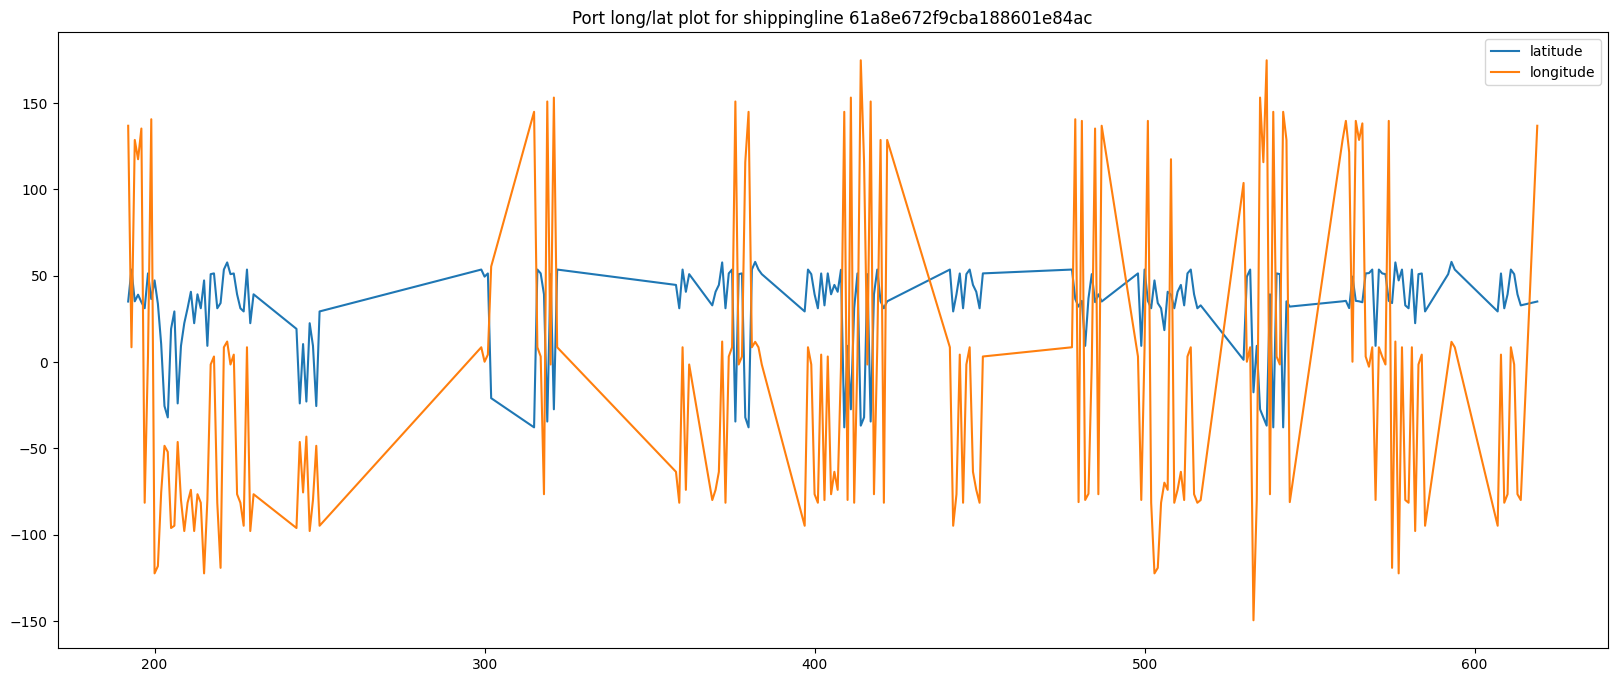

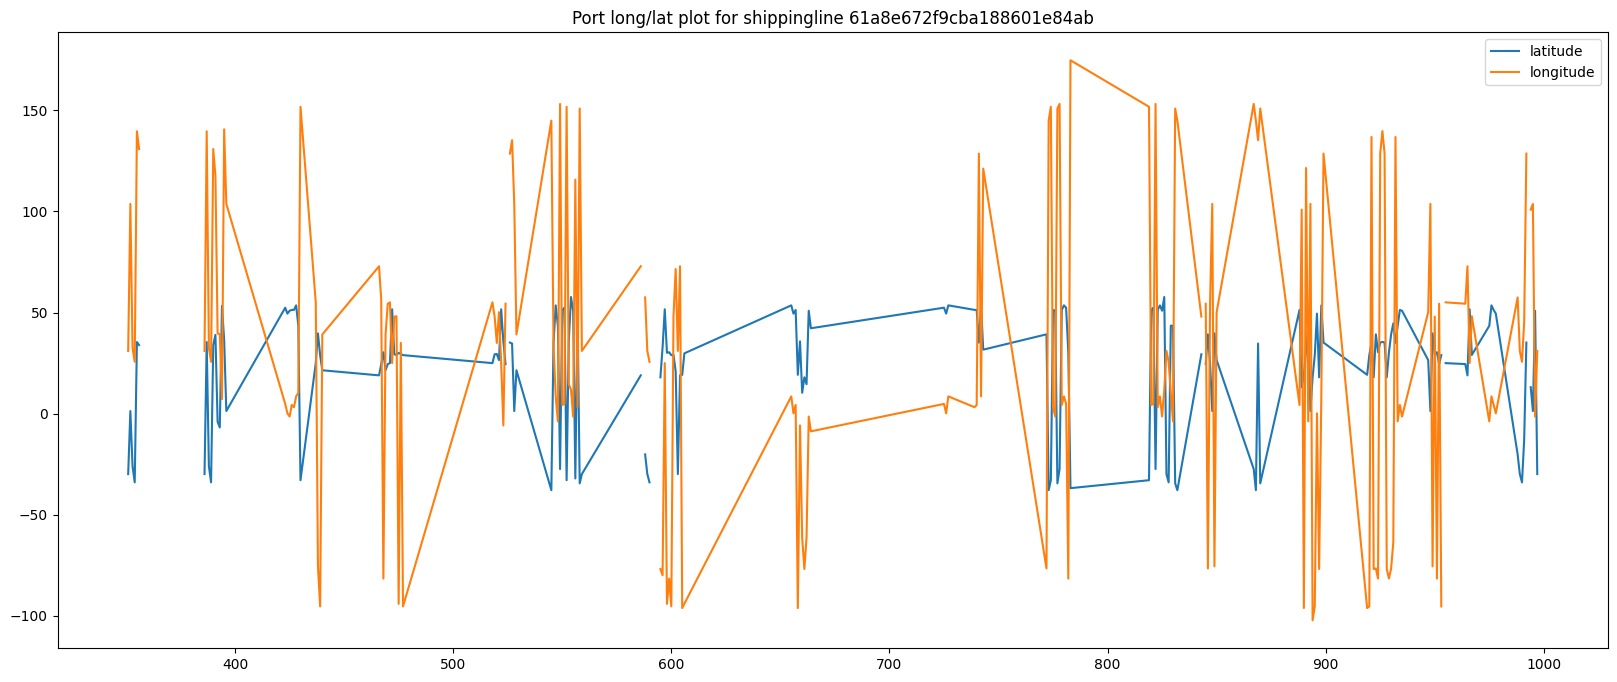

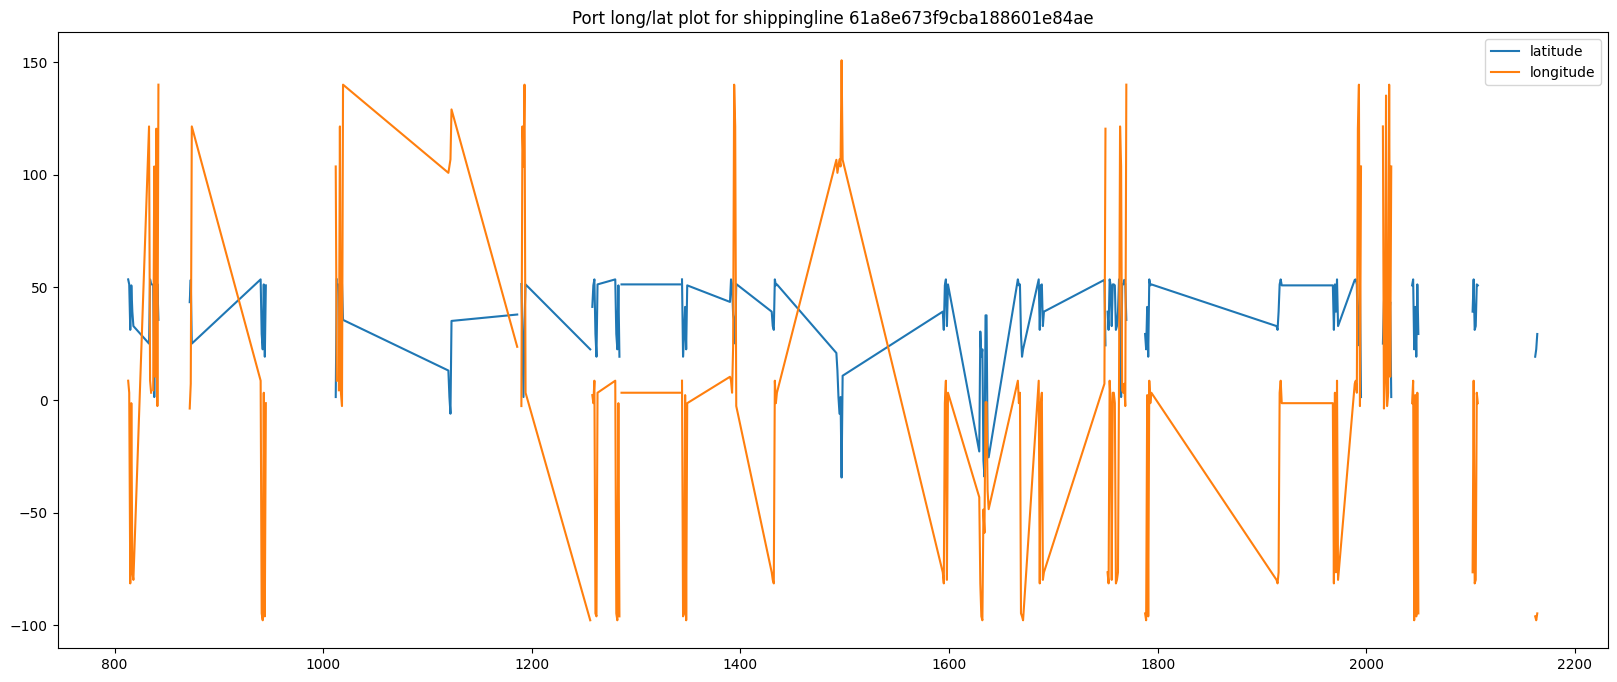

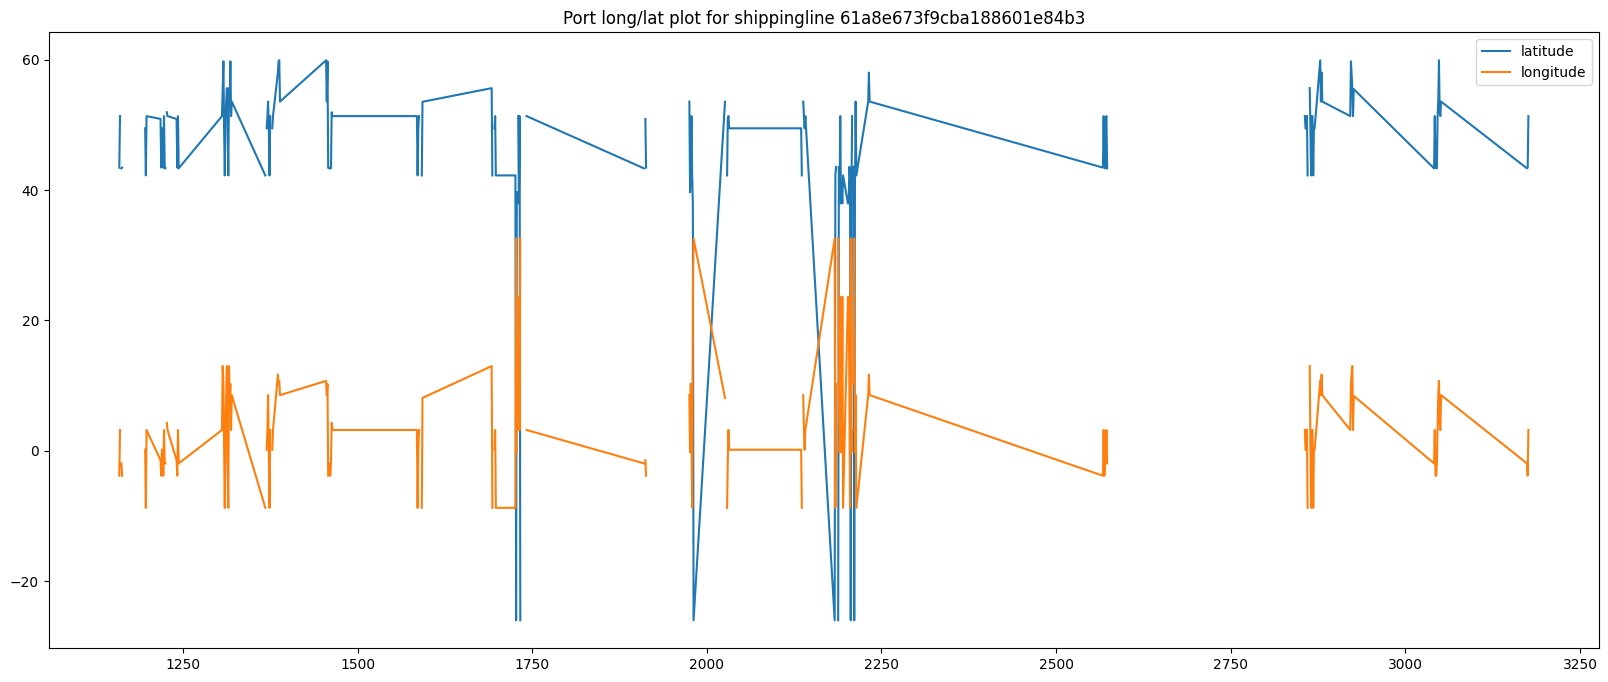

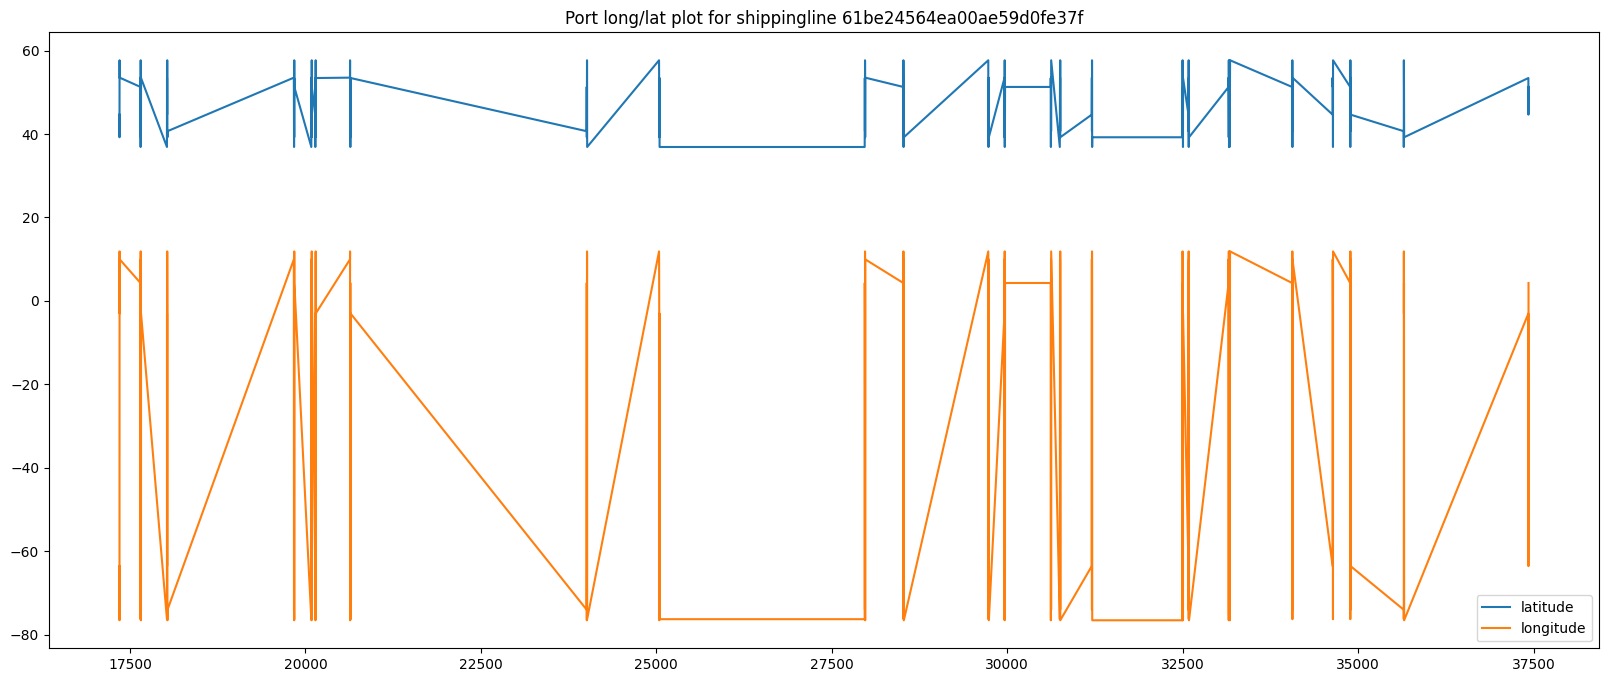

In [57]:
shippinglines = schedules_df['shippingLineId'].unique()

data_shippingline0 = schedules_df[schedules_df['shippingLineId'] == shippinglines[0]]
start = 100
stop = 300


plt.figure(figsize = (20,8))
plt.title(f'Port long/lat plot for shippingline {shippinglines[0]}')
plt.plot(data_shippingline0['portLatitude'][start:stop], label = 'latitude')
plt.plot(data_shippingline0['portLongitude'][start:stop], label = 'longitude')
plt.legend()

data_shippingline1 = schedules_df[schedules_df['shippingLineId'] == shippinglines[1]]

plt.figure(figsize = (20,8))
plt.title(f'Port long/lat plot for shippingline {shippinglines[1]}')
plt.plot(data_shippingline1['portLatitude'][start:stop], label =  'latitude')
plt.plot(data_shippingline1['portLongitude'][start:stop], label = 'longitude')
plt.legend()

data_shippingline2 = schedules_df[schedules_df['shippingLineId'] == shippinglines[2]]

plt.figure(figsize = (20,8))
plt.title(f'Port long/lat plot for shippingline {shippinglines[2]}')
plt.plot(data_shippingline2['portLatitude'][start:stop], label =  'latitude')
plt.plot(data_shippingline2['portLongitude'][start:stop], label = 'longitude')
plt.legend()

data_shippingline3 = schedules_df[schedules_df['shippingLineId'] == shippinglines[3]]

plt.figure(figsize = (20,8))
plt.title(f'Port long/lat plot for shippingline {shippinglines[3]}')
plt.plot(data_shippingline3['portLatitude'][start:stop], label =  'latitude')
plt.plot(data_shippingline3['portLongitude'][start:stop], label = 'longitude')
plt.legend()

data_shippingline4 = schedules_df[schedules_df['shippingLineId'] == shippinglines[4]]

plt.figure(figsize = (20,8))
plt.title(f'Port long/lat plot for shippingline {shippinglines[4]}')
plt.plot(data_shippingline4['portLatitude'][start:stop], label =  'latitude')
plt.plot(data_shippingline4['portLongitude'][start:stop], label = 'longitude')
plt.legend()


In [19]:
print(len(schedules_df['shippingLineId'].unique()))
print(len(vessels_df['shippingLineId'].unique()))

5
27


In [79]:
features = ['minute', 'day_of_week', 'hour','vesselId', 'shippingLineId', 'latitude_portId_1', 'longitude_portId_1', 'latitude_1' , 'longitude_1', 'heading_1', 'sog_1']
targets = ['latitude', 'longitude', 'latitude_portId', 'longitude_portId', 'heading', 'sog']

X = train_df[features]
y = train_df[targets]

params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'eta':  0.01,
}

dtrain = xgb.DMatrix(X, label = y)
evals = [(dtrain, 'train')]
model_port_coord = xgb.train(params, dtrain, num_boost_round= 1000, evals = evals, verbose_eval= 10)


[0]	train-rmse:83.97039
[10]	train-rmse:76.44620
[20]	train-rmse:69.68910
[30]	train-rmse:63.62868
[40]	train-rmse:58.20269
[50]	train-rmse:53.35233
[60]	train-rmse:49.02628
[70]	train-rmse:45.18187
[80]	train-rmse:41.77328
[90]	train-rmse:38.76020
[100]	train-rmse:36.10651
[110]	train-rmse:33.77846
[120]	train-rmse:31.74486
[130]	train-rmse:29.97508
[140]	train-rmse:28.44347
[150]	train-rmse:27.12380
[160]	train-rmse:25.98989
[170]	train-rmse:25.02003
[180]	train-rmse:24.19490
[190]	train-rmse:23.49536
[200]	train-rmse:22.90380
[210]	train-rmse:22.40504
[220]	train-rmse:21.98520
[230]	train-rmse:21.63277
[240]	train-rmse:21.33900
[250]	train-rmse:21.09315
[260]	train-rmse:20.88838
[270]	train-rmse:20.71508
[280]	train-rmse:20.57103
[290]	train-rmse:20.44862
[300]	train-rmse:20.34525
[310]	train-rmse:20.25627
[320]	train-rmse:20.18093
[330]	train-rmse:20.11570
[340]	train-rmse:20.06083
[350]	train-rmse:20.01391
[360]	train-rmse:19.97496
[370]	train-rmse:19.94134
[380]	train-rmse:19.911

In [80]:
lat_pred = []
long_pred = []
lat_portId_pred = []
long_portId_pred = []
head_pred = []
sog_pred = []
predictions = []
last_position = {}

display(train_df['vesselId'].unique())
display(test_df['vesselId'].unique())

for index, row in test_df.iterrows():
    vessel = row['vesselId']
    if(vessel in last_position):
        lat,long, lat_portId, long_portId, heading, sog = last_position[vessel]
    else:
        lat = np.array(train_df[train_df['vesselId']  == vessel]['latitude'])[-1] 
        long = np.array(train_df[train_df['vesselId']  == vessel]['longitude'])[-1]
        lat_portId = np.array(train_df[train_df['vesselId']  == vessel]['latitude_portId'])[-1]
        long_portId = np.array(train_df[train_df['vesselId']  == vessel]['longitude_portId'])[-1]
        heading = np.array(train_df[train_df['vesselId']  == vessel]['heading'])[-1]
        sog = np.array(train_df[train_df['vesselId']  == vessel]['sog'])[-1]
            
    print(index, end = '\r')
    X_data = {'minute':row['minute'] , 'day_of_week':row['day_of_week'], 'hour':row['hour'], 'vesselId': row['vesselId'], 'shippingLineId': row['shippingLineId'], 'latitude_portId_1':lat_portId, 'longitude_portId_1':long_portId, 'latitude_1':lat, 'longitude_1':long, 'heading_1':heading, 'sog_1':sog}
    X = pd.DataFrame(data = X_data, index = [0])
    dtest = xgb.DMatrix(X)
    prediction = model_port_coord.predict(dtest)
    last_position[vessel] = prediction[0]   
    lat_pred.append(prediction[0][0])
    long_pred.append(prediction[0][1])
    lat_portId_pred.append(prediction[0][2])
    long_portId_pred.append(prediction[0][3])
    head_pred.append(prediction[0][4])
    sog_pred.append(prediction[0][5])
    predictions.append(prediction[0])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

array([ 84, 623, 596, 542,   1, 686, 161,  91, 490, 176,  85, 593, 649,
       163, 244, 658, 671, 652, 164, 579, 662, 382, 299, 327, 270, 515,
       591, 564, 576, 580,  76, 397, 167, 177, 575,  82, 249,  23, 275,
       401, 517, 333, 640, 605, 133, 642, 421, 482, 367, 117, 204, 487,
        62, 354, 650,  71, 661, 286, 554, 615, 128,  31, 545, 281,  94,
       328, 585, 567, 569, 609, 677, 681, 659, 603, 485, 541, 465, 624,
        53, 472, 201, 398, 175, 475, 568,  97, 644, 122, 292, 341, 599,
       684, 395, 432, 240, 151, 467, 501,  41,  21, 195, 233, 632, 466,
       584, 444, 602, 294, 400, 463, 682, 236,  38, 155, 336, 562, 290,
       153, 604,  37, 230, 338, 169, 578, 332, 433, 570, 643, 399, 587,
       402, 687, 364, 648, 196,  34, 581, 573,  46, 560, 552, 588, 339,
       469,  59, 419, 608, 330, 597,  28, 392,  80, 212, 387, 647, 209,
       509, 614, 474, 664, 574, 148, 320, 344, 443, 213, 590, 457, 563,
       565, 461, 166, 158, 329, 494, 571, 572, 134, 594, 162, 45

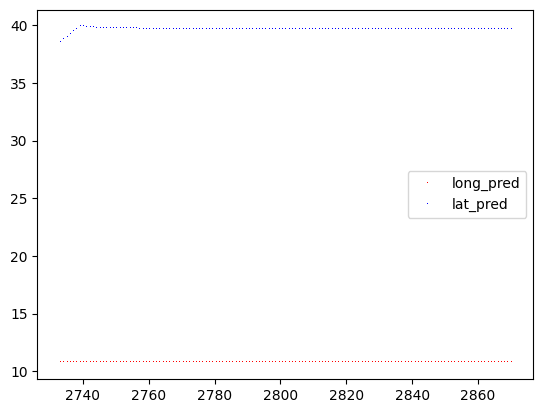

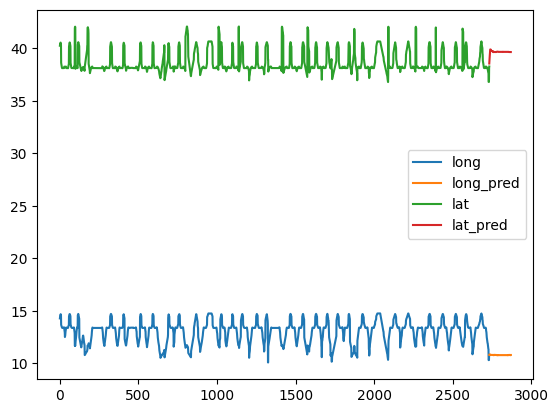

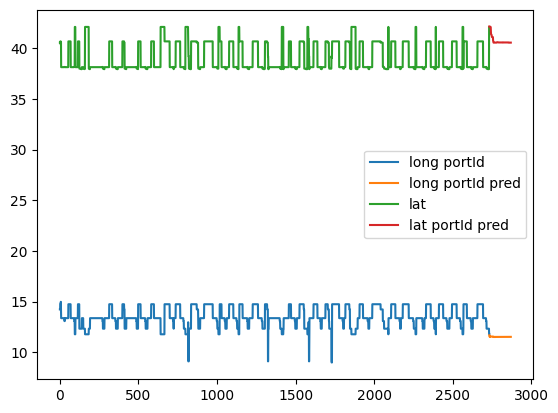

In [84]:
predictions = np.array(predictions)

latitudes_predicted = predictions[:,0] 
longitudes_predicted = predictions[:,1] 

test_df['longitude_predicted'] = long_pred
test_df['latitude_predicted'] = lat_pred
test_df['longitude_portId_predicted'] = long_portId_pred
test_df['latitude_portId_predicted'] = lat_portId_pred

vesselId = 2
vessel = test_df['vesselId'].unique()[vesselId]

vessel_data_train = train_df[train_df['vesselId'] == vessel]
vessel_data_test = test_df[test_df['vesselId'] == vessel]

N = len(vessel_data_train['longitude'])
M = len(vessel_data_test['longitude_predicted'])

index_train = np.linspace(0, N,N)
index_test = np.linspace(N, N+M,M)

plt.plot(index_test, vessel_data_test['longitude_predicted'], 'r,', label = 'long_pred')
plt.plot(index_test, vessel_data_test['latitude_predicted'], 'b,', label = 'lat_pred')
plt.legend()
plt.figure()
plt.plot(index_train, vessel_data_train['longitude'], label = 'long')
plt.plot(index_test, vessel_data_test['longitude_predicted'], label = 'long_pred')
plt.plot(index_train, vessel_data_train['latitude'],label = 'lat')
plt.plot(index_test, vessel_data_test['latitude_predicted'], label = 'lat_pred')
plt.legend()

plt.figure()
plt.plot(index_train, vessel_data_train['longitude_portId'], label = 'long portId')
plt.plot(index_test, vessel_data_test['longitude_portId_predicted'], label = 'long portId pred')
plt.plot(index_train, vessel_data_train['latitude_portId'],label = 'lat')
plt.plot(index_test, vessel_data_test['latitude_portId_predicted'], label = 'lat portId pred')
plt.legend()

In [85]:
submission = pd.DataFrame(test_df[['ID','longitude_predicted', 'latitude_predicted']])
submission.to_csv('submission_17_10.csv', index = False)

In [86]:
from geopy.distance import geodesic
submission_best = pd.read_csv('predictions_beste.csv')
submission_today = pd.read_csv('submission_17_10.csv')
latitude_best = submission_best['latitude_predicted']
longitude_best = submission_best['longitude_predicted']
latitudes_today = submission_today['latitude_predicted']
longitudes_today = submission_today['longitude_predicted']
distances = []
weights = test_df['scaling_factor']
for i in range(len(longitude_best)):
    distance = geodesic((latitude_best[i], longitude_best[i]), 
                        (latitudes_today[i], longitudes_today[i])).meters
    distances.append(distance*weights[i])

print((np.mean(distances)) /1000)
    
    

92.91026866458495
